# Multi-factor Enhanced Index Research (S&P500) <a class="tocSkip">

[Context](https://www.joinquant.com/view/community/detail/8c60c343407d41b09def615c52c8693d?type=1#%E5%9B%9B%E3%80%81%E5%9B%A0%E5%AD%90%E5%A4%9A%E9%87%8D%E5%85%B1%E7%BA%BF%E6%80%A7%E7%9A%84%E5%A4%84%E7%90%86)

In [1]:
import os
import requests
import pandas as pd
import numpy as np
from dateutil.parser import parse
import datetime
from dotenv import load_dotenv, find_dotenv

import statsmodels.api as sm
import scipy
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

from pprint import pprint

In [2]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 20)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


load_dotenv(find_dotenv(), verbose=True, override=True)

TIINGO_API_TOKEN = os.getenv('TIINGO_API_TOKEN')

# Helper Functions

## Tiingo module to get price and fundamental data

In [3]:
__headers = {
    'Content-Type': 'application/json'
}
__token = TIINGO_API_TOKEN

In [4]:
def load_meta() -> str:
    fundamental_meta_data_path = f'./data/meta.json'
    with open(fundamental_meta_data_path, 'r') as fp:
        content=fp.read()
    content = json.loads(content)
    return content

In [5]:
def get_price(symbol, start_date=None, end_date=None, resampleFreq='daily'):
    
    start_param = 'startDate={}'.format(start_date) if start_date is not None else ''
    end_param = '&endDate={}'.format(end_date) if end_date is not None else ''
    pricing_daily_url = 'https://api.tiingo.com/tiingo/daily/{}/prices?token={}&{}{}&resampleFreq={}'.format(symbol, __token, start_param, end_param, resampleFreq)

    try:
        pricing_daily_data = requests.get(
            url=pricing_daily_url,
            headers=__headers
        )
    except Exception as e:
        raise(e)
    else:
        if pricing_daily_data.status_code == 200:
            return pricing_daily_data.json()
    print('[{}] "pricing_daily_url" doesn\'t return successfully'.format(symbol))
    return None

In [6]:
def get_daily_fundamental(symbol, start_date=None, end_date=None):
    
    start_param = 'startDate={}'.format(start_date) if start_date is not None else ''
    end_param = '&endDate={}'.format(end_date) if end_date is not None else ''
    fundamental_daily_fundamental_url = 'https://api.tiingo.com/tiingo/fundamentals/{}/daily?token={}&{}{}'.format(symbol, __token, start_param, end_param)
    
    try:
        fundamental_daily_fundamental_data = requests.get(
            url=fundamental_daily_fundamental_url,
            headers=__headers
        )
    except Exception as e:
        raise(e)
    else:
        if fundamental_daily_fundamental_data.status_code == 200:
            return fundamental_daily_fundamental_data.json()
    print('[{}] "fundamental_daily_fundamental_url" doesn\'t return successfully'.format(symbol))
    return None

In [7]:
def get_quarterly_fundamental(symbol, start_date=None, end_date=None):
    
    start_param = 'startDate={}'.format(start_date) if start_date is not None else ''
    end_param = '&endDate={}'.format(end_date) if end_date is not None else ''
    fundamental_quarterly_url = 'https://api.tiingo.com/tiingo/fundamentals/{}/statements?token={}&{}{}'.format(symbol, __token, start_param, end_param)
    
    try:
        fundamental_quarterly_data = requests.get(
            url=fundamental_quarterly_url,
            headers=__headers
        )
    except Exception as e:
        raise(e)
    else:
        if fundamental_quarterly_data.status_code == 200:
            return fundamental_quarterly_data.json()
    print('[{}] "fundamental_quarterly_url" doesn\'t return successfully'.format(symbol))
    return None

In [8]:
def normalize_fundamental_quarterly_data(data):
    """[summary]

    Args:
        data ([type]): [description]

    Returns:
        [type]: [description]
    """
    df = pd.json_normalize(data)

    sheets = [
        'statementData.balanceSheet',
        'statementData.cashFlow',
        'statementData.incomeStatement',
        'statementData.overview'
    ]

    for col in sheets:
        if col not in df.columns:
            continue

        fdf = None
        for i in df.index:
            dic = {}

            if df.iloc[i][col] is np.NaN:
                continue
            for item in df.iloc[i][col]:
                code = None
                value = None
                for k in item.keys():
                    if k == 'dataCode':
                        code = item[k]
                    if k == 'value':
                        value = item[k]
                dic[code] = value
            data = [x for x in dic.values()]
            cols = [col + '.' + x for x in dic.keys()]

            if fdf is None:
                fdf = pd.DataFrame(np.array([data]), index=[i], columns=cols)
            else:
                fdf = fdf.append(pd.DataFrame(np.array([data]), index=[i], columns=cols))
        df = pd.concat([df, fdf], axis=1)
        df = df.drop([col], axis=1)

    df['date'] = df['date'].astype('datetime64[ns]')
    return df

---

## Filter Stocks

In [9]:
def cleanup_stock_list(stock_list) -> list:
    stock_list = [s.lower() for s in stock_list]
    stock_list = [s if s != 'brk.b' else 'brk-b' for s in stock_list]
    stock_list = [s if s != 'bf.b' else 'bf-b' for s in stock_list]
    stock_list = [s if s != 'chk' else 'chkaq' for s in stock_list]
    stock_list = [s if s != 'dps' else 'kdp' for s in stock_list]
    
    # WYN spun-off to WH
    stock_list = [s if s != 'wyn' else 'wh' for s in stock_list]

    # Fundamental not found
    stock_list = [s for s in stock_list if s not in ['frc']]

    # Class B or C
    # goog => googl
    # ua => uaa
    # fox => foxa
    # nws => nwsa
    # disck => disca
    stock_list = [s for s in stock_list if s not in ['ua','fox', 'goog', 'nws', 'disck']]

    # Stock was acquired by another company @ 2018-01-03
    stock_list = [s for s in stock_list if s not in ['bcr']]

    # Stock fundamental is only available before 2018-01-01
    stock_list = [s for s in stock_list if s not in ['csra', 'sni']]
    
    # Symbol changed
    stock_list = [s for s in stock_list if s not in ['dwdp']]
    return stock_list

In [10]:
def get_current_snp_tickers() -> list:
    _header = {
        'authority': 'www.slickcharts.com',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.146 Safari/537.36'
    }
    
    res = requests.get('https://www.slickcharts.com/sp500', headers=_header)
    snp500_current = pd.read_html(res.content, index_col=0)
    
    # The latest S&P 500 composition (https://www.slickcharts.com/sp500)
    l = snp500_current[0].Symbol.to_list()
    
    return l

In [88]:
def get_snp_stock_scaffolding(start_date, end_date, freq='daily'):
    data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

    # Get current S&P table and set header column
    sp500 = data[0].iloc[1:,[0,1,6,7]]
    columns = ['added_ticker', 'name', 'date', 'cik']
    sp500.columns = columns
    sp500.loc[sp500['date'].isnull(), 'date'] = '1957-01-01'

    # One date is in the wrong format. Correcting it.
    sp500.loc[:,'date'] = sp500.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x[:10],'%Y-%m-%d'))
    sp500 = pd.melt(sp500, id_vars=['date', 'name', 'cik'], value_vars=['added_ticker'])

    sp500_adjustments = data[1]
    sp500_adjustments = sp500_adjustments[2:].copy()
    columns = ['date', 'added_ticker', 'added_name', 'removed_ticker', 'removed_name', 'reason']
    sp500_adjustments.columns = columns
    updates = sp500_adjustments[~sp500_adjustments['date'].str.contains(',')].T.shift(1).T
    sp500_adjustments['date'].loc[~sp500_adjustments['date'].str.contains(',')] = np.nan
    sp500_adjustments[sp500_adjustments['added_ticker'].isnull()]
    sp500_adjustments.update(updates)
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_adjustments['date'].loc[sp500_adjustments['date'].isnull()] = sp500_adjustments['date'].T.shift(1).T
    sp500_additions = sp500_adjustments[~sp500_adjustments['added_ticker'].isnull()]
    sp500_additions = sp500_additions[['date', 'added_ticker', 'added_name']]
    sp500_additions.rename(columns={'added_name': 'name'}, inplace=True)
    sp500_additions = pd.melt(sp500_additions, id_vars=['date','name'], value_vars=['added_ticker'])
    sp500_deletions = sp500_adjustments[~sp500_adjustments['removed_ticker'].isnull()]
    sp500_deletions = sp500_deletions[['date', 'removed_ticker', 'removed_name']]
    sp500_deletions.rename(columns={'removed_name': 'name'}, inplace=True)
    sp500_deletions = pd.melt(sp500_deletions, id_vars=['date','name'], value_vars=['removed_ticker'])
    sp500_history = pd.concat([sp500_deletions, sp500_additions])
    
    df = pd.concat([sp500, sp500_history], ignore_index=True)
    df['date'] = pd.to_datetime(df['date'], utc=True)
    df.sort_values(by='cik', ascending=False, inplace=True)
    deduped_df = df[~df.duplicated(['date', 'variable', 'value'])].copy()    
    deduped_df = deduped_df.sort_values(['date', 'variable']).set_index(['date', 'variable'])

    l = get_current_snp_tickers()
    dictionary = {}

    for d in deduped_df.index.levels[0][::-1]:
        if 'added_ticker' in deduped_df.loc[pd.to_datetime(d),:].index:
            removed_stock_list = [s.upper() for s in deduped_df.loc[(pd.to_datetime(d), 'added_ticker'), 'value'].values]
        else:
            removed_stock_list = []

        if 'removed_ticker' in deduped_df.loc[pd.to_datetime(d),:].index:
            added_stock_list = [s.upper() for s in deduped_df.loc[(pd.to_datetime(d), 'removed_ticker'), 'value'].values]
        else:
            added_stock_list = []

        l = [x.upper() for x in (l + added_stock_list) if x not in removed_stock_list]
        l = list(set(l))
        dictionary[d] = l

        if d <= pd.to_datetime(START_DATE, utc=True):
            break

    if freq == 'daily':
        # Business Day
        re = pd.DataFrame(index=pd.to_datetime(pd.date_range(start_date, end_date, freq = 'B'), utc=True))
    elif freq == 'weekly':
        # business month start frequency
        re = pd.DataFrame(index=pd.to_datetime(pd.date_range(START_DATE,END_DATE, freq = 'BMS'), utc=True))

    re['ticker'] = pd.DataFrame([dictionary]).T
    re = re.ffill().dropna()
    re = re.explode('ticker').reset_index().sort_values(['index', 'ticker'])
    re['ticker'] = re['ticker'].str.lower()
    re = re.set_index(['index', 'ticker'])
    re.index.rename(['date', 'ticker'], inplace=True)
    return re

---

## Fetching data

In [47]:
def download_csv_data(symbol, start_date, end_date=None, freq='daily', path=None):
    '''
    Function for downloading data from Tiingo and storing the results in a CSV file

    Parameters
    ------------
    symbol : str
        The symbol of the assset
    start_date : str
        The start date for downloading the data
    end_date : str
        The end date for downloading the data
    path : str
        The path to store the CSV file
    freq : str
        The frequency of the data
    '''
    df_path=os.path.join(path, f'{symbol}.csv')
    fund_df_path=os.path.join(path, f'{symbol}_fund.csv')
    
    if os.path.exists(df_path):
        print(f'{symbol}.csv exists')
        return
    
    df = pd.DataFrame(get_price(symbol, start_date, end_date, freq))
    df2 = pd.DataFrame(get_daily_fundamental(symbol, start_date, end_date))
    df3 = normalize_fundamental_quarterly_data(get_quarterly_fundamental(symbol, start_date, end_date))
    df3 = df3[~df3['quarter'].isin([0])]    # Remove the records that quarter = 0
    
    df['date'] = pd.to_datetime(df['date'], utc=True)
    df2['date'] = pd.to_datetime(df2['date'], utc=True)
    df3['date'] = pd.to_datetime(df3['date'], utc=True)

    dd = pd.merge(df, df2, on='date', how='left')
    dd = dd.ffill()
    df3 = df3.ffill()
    df3 = df3[~df3['quarter'].isin([0])]

    dd.to_csv(df_path, header=True, index=True)
    df3.to_csv(fund_df_path, header=True, index=True)
        
    del df
    del df2
    del df3
    del dd

In [48]:
def load_data(symbol, start_date, end_date=None, freq='daily', path=None):
    df_path=f'{path}/{symbol}.csv'
    fund_df_path=f'{path}/{symbol}_fund.csv'
    
    try:
        df = pd.read_csv(df_path, index_col=0)
        fund_df = pd.read_csv(fund_df_path, index_col=0)
    except Exception as e:
        raise(e)
        
    return df, fund_df

---

# Constucting Factors

## Define factors

### Quaterly available factor set

In [15]:
def EPTTM(df, qdf):
    '''
    Cagetory: Estimation
    Name: Reciprocal of pe_ratio TTM (For Trailing Twelve Months)
    Description: 市盈率倒数 TTM
    Method: Earning / Market Value
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.incomeStatement.eps']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    
    tmp['trailing_eps'] = tmp['statementData.incomeStatement.eps'].rolling(4).mean()

    tmp = pd.merge(df, tmp[['date', 'trailing_eps']], on='date', how='outer').sort_values('date')
    tmp['trailing_eps'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['ep_ratio'] = tmp['trailing_eps'] / tmp['adjClose']

    return tmp['ep_ratio']
    


def SPTTM(df, qdf):
    '''
    Cagetory: Estimation
    Name: Reciprocal of ps_ratio TTM (For Trailing Twelve Months)
    Description: 市销率倒数 TTM
    Method: Sales Income / Market Value
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.overview.rps']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    
    tmp['trailing_rps'] = tmp['statementData.overview.rps'].rolling(4).mean()

    tmp = pd.merge(df, tmp[['date', 'trailing_rps']], on='date', how='outer').sort_values('date')
    tmp['trailing_rps'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['sp_ratio'] = tmp['trailing_rps'] / tmp['adjClose']

    return tmp['sp_ratio']


def SUE0(df, qdf):
    '''
    Cagetory: Growth
    Name: Standardized unexpected profit
    Description: 标准化预期外盈利
    Method: (单季度实际净利润-预期净利润)/预期净利润标准差
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.incomeStatement.revenue', 'statementData.incomeStatement.costRev']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['net_revenue'] = tmp['statementData.incomeStatement.revenue'] - tmp['statementData.incomeStatement.costRev']
    tmp['previous_quarter'] = tmp['net_revenue'].shift(1)
    tmp['this_quarter_shift_4'] = tmp['net_revenue'].shift(4)
    tmp['previous_quarter_shift_4'] = tmp['previous_quarter'].shift(4)
    tmp['C'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).mean()
    tmp['epsilon'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).std()
    tmp['Q'] = tmp['this_quarter_shift_4'] + tmp['C'] + tmp['epsilon']
    tmp['SUE0'] = (tmp['net_revenue'] - tmp['Q']) / tmp['epsilon']
    
    tmp = pd.merge(df, tmp[['date', 'SUE0']], on='date', how='outer').sort_values('date')
    tmp['SUE0'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['SUE0']


def SUR0(df, qdf):
    '''
    Cagetory: Growth
    Name: Standardized unexpected revenue
    Description: 标准化预期外收入
    Method: (单季度实际营业收入-预期营业收入)/预期营业收入标准差
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.incomeStatement.opinc']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['previous_quarter'] = tmp['statementData.incomeStatement.opinc'].shift(1)
    tmp['this_quarter_shift_4'] = tmp['statementData.incomeStatement.opinc'].shift(4)
    tmp['previous_quarter_shift_4'] = tmp['previous_quarter'].shift(4)
    tmp['C'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).mean()
    tmp['epsilon'] = (tmp['previous_quarter'] - tmp['previous_quarter_shift_4']).rolling(4).std()
    tmp['Q'] = tmp['this_quarter_shift_4'] + tmp['C'] + tmp['epsilon']
    tmp['SUR0'] = (tmp['statementData.incomeStatement.opinc'] - tmp['Q']) / tmp['epsilon']
    
    tmp = pd.merge(df, tmp[['date', 'SUR0']], on='date', how='outer').sort_values('date')
    tmp['SUR0'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['SUR0']
    

def DELTAROE(df, qdf):
    '''
    Cagetory: Profit
    Name: Quarter-on-quarter ROE ratio
    Description: 单季度净资产收益率同比变化
    Method: 单季度净资产收益率-去年同期单季度净资产收益率
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.overview.roe']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['last_year_roe'] = tmp['statementData.overview.roe'].shift(-4)
    tmp['DELTAROE'] = tmp['statementData.overview.roe'] - tmp['last_year_roe']

    tmp = pd.merge(df, tmp[['date', 'DELTAROE']], on='date', how='outer').sort_values('date')
    tmp['DELTAROE'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['DELTAROE']


def DELTAROA(df, qdf):
    '''
    Cagetory: Profit
    Name: Quarter-on-quarter ROA ratio
    Description: 单季度总资产收益率同比变化
    Method: 单季度总资产收益率-去年同期单季度中资产收益率
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'statementData.overview.roa']
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['last_year_roa'] = tmp['statementData.overview.roa'].shift(-4)
    tmp['DELTAROA'] = tmp['statementData.overview.roa'] - tmp['last_year_roa']

    tmp = pd.merge(df, tmp[['date', 'DELTAROA']], on='date', how='outer').sort_values('date')
    tmp['DELTAROA'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['DELTAROA']

def net_profit_growth_rate(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'year', 'quarter', 'statementData.incomeStatement.revenue', 'statementData.incomeStatement.costRev']
    quarter_window = 4
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['net_profit'] = tmp['statementData.incomeStatement.revenue'] - tmp['statementData.incomeStatement.costRev']
    tmp['net_profit_TTM'] = tmp['net_profit'].rolling(quarter_window).sum()
    tmp['net_profit_TTM_shift_4'] = tmp['net_profit_TTM'].shift(quarter_window)
    tmp['net_profit_growth_rate'] = (tmp['net_profit_TTM'] / tmp['net_profit_TTM_shift_4']) - 1

    tmp = pd.merge(df, tmp[['date', 'net_profit_growth_rate']], on='date', how='outer').sort_values('date')
    tmp['net_profit_growth_rate'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['net_profit_growth_rate']


def operating_revenue_growth_rate(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'year', 'quarter', 'statementData.incomeStatement.opinc']
    quarter_window = 4
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['revenue_TTM'] = tmp['statementData.incomeStatement.opinc'].rolling(quarter_window).sum()
    tmp['revenue_TTM_shift_4'] = tmp['revenue_TTM'].shift(quarter_window)
    tmp['total_revenue_growth_rate'] = (tmp['revenue_TTM'] / tmp['revenue_TTM_shift_4']) - 1

    tmp = pd.merge(df, tmp[['date', 'total_revenue_growth_rate']], on='date', how='outer').sort_values('date')
    tmp['total_revenue_growth_rate'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['total_revenue_growth_rate']


def total_profit_growth_rate(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    qdf.sort_values('date', inplace=True)
    
    fields = ['date']
    quarter_fields = ['date', 'year', 'quarter', 'statementData.incomeStatement.revenue']
    quarter_window = 4
    
    tmp = qdf[quarter_fields].copy(deep=True)
    tmp['profit_TTM'] = tmp['statementData.incomeStatement.revenue'].rolling(quarter_window).sum()
    tmp['profit_TTM_shift_4'] = tmp['profit_TTM'].shift(quarter_window)
    tmp['total_profit_growth_rate'] = (tmp['profit_TTM'] / tmp['profit_TTM_shift_4']) - 1

    tmp = pd.merge(df, tmp[['date', 'total_profit_growth_rate']], on='date', how='outer').sort_values('date')
    tmp['total_profit_growth_rate'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['total_profit_growth_rate']


def roe_ttm(df, qdf):
    '''
    Cagetory: Estimation
    Name: Reciprocal of pe_ratio TTM (For Trailing Twelve Months)
    Description: 市盈率 TTM
    Method: Earning / Market Value
    '''
    qdf.sort_values('date', inplace=True)
    
    field = ['date']
    quarter_field = ['date', 'statementData.overview.roe']
    window = 20
    quarter_window = 4
    
    tmp = qdf[quarter_field].copy(deep=True)
    
    tmp['ROE_TTM'] = tmp['statementData.overview.roe'].rolling(quarter_window).sum()
        
    tmp = pd.merge(df, tmp[['date', 'ROE_TTM']], on='date', how='outer').sort_values('date')
    tmp['ROE_TTM'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['ROE_TTM']


def roa_ttm(df, qdf):
    '''
    Cagetory: Estimation
    Name: Reciprocal of pe_ratio TTM (For Trailing Twelve Months)
    Description: 市盈率 TTM
    Method: Earning / Market Value
    '''
    qdf.sort_values('date', inplace=True)
    
    field = []
    quarter_field = ['date', 'statementData.overview.roa']
    window = 20
    quarter_window = 4
    
    tmp = qdf[quarter_field].copy(deep=True)
    
    tmp['ROA_TTM'] = tmp['statementData.overview.roa'].rolling(quarter_window).sum()
        
    tmp = pd.merge(df, tmp[['date', 'ROA_TTM']], on='date', how='outer').sort_values('date')
    tmp['ROA_TTM'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]

    return tmp['ROA_TTM']

### Daily available factor set

In [16]:
def ILLIQ(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    # ! We should use trading money instead of trading volume.
    # ! Trading money = the money amount that has been traded on the market
    fields = ['adjClose', 'adjVolume']
    window = 20
    tmp = df[fields].copy(deep=True)
    tmp.ffill(inplace=True)
    
    tmp['pct_change'] = df['adjClose'].pct_change()
    tmp['Vol'] = df['adjVolume']
    tmp['pct_vol'] = tmp['pct_change'] / tmp['Vol']
    tmp['ILLIQ'] = tmp['pct_vol'].rolling(window).mean().shift(1)

    return tmp['ILLIQ']

    
def ATR1M(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 过去20个交易日日内真实波幅均值
    Method: 
    '''

    fields = ['date','adjHigh', 'adjLow', 'adjClose']
    window = 20
    tmp = df[fields].copy(deep=True)
    tmp.ffill(inplace=True)
    
    tmp['high'] = tmp['adjHigh'].shift(1)
    tmp['low'] = tmp['adjLow'].shift(1)
    tmp['close'] = tmp['adjClose'].shift(1)
    
    tmp['hml'] = tmp['high'] - tmp['low']
    tmp['cmh'] = (tmp['close'].shift(1) - tmp['high']).abs()
    tmp['cml'] = (tmp['close'].shift(1) - tmp['low']).abs()
    
    tmp['TR'] = tmp[['hml', 'cmh', 'cml']].max(axis=1, skipna=False)
    tmp['ATR1M'] = tmp['TR'].rolling(window).mean().shift(1)
    
    return tmp['ATR1M']
    
def ATR3M(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 过去60个交易日日内真实波幅均值
    Method: 
    '''

    fields = ['date','adjHigh', 'adjLow', 'adjClose']
    window = 60
    tmp = df[fields].copy(deep=True)
    tmp.fillna(0, inplace=True)
    
    tmp['high'] = tmp['adjHigh'].shift(1)
    tmp['low'] = tmp['adjLow'].shift(1)
    tmp['close'] = tmp['adjClose'].shift(1)
    
    tmp['hml'] = tmp['high'] - tmp['low']
    tmp['cmh'] = (tmp['close'].shift(1) - tmp['high']).abs()
    tmp['cml'] = (tmp['close'].shift(1) - tmp['low']).abs()
    
    tmp['TR'] = tmp[['hml', 'cmh', 'cml']].max(axis=1, skipna=False)
    tmp['ATR3M'] = tmp['TR'].rolling(window).mean().shift(1)
    
    return tmp['ATR3M']


def natural_log_of_market_cap(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    fields = ['date', 'marketCap']
    
    tmp = df[fields].copy(deep=True)
    tmp['ln_of_market_cap'] = tmp['marketCap'].apply(np.log).shift(1)
                              
    return tmp['ln_of_market_cap']


def book_to_price_ratio(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    fields = ['date', 'pbRatio']
    
    tmp = df[fields].copy(deep=True)
    tmp['book_to_price'] = (1 / tmp['pbRatio']).shift(1)

    return tmp['book_to_price']


def ROC20(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
        1. AX=今天的收盘价—20天前的收盘价
        2. BX=20天前的收盘价
        3. ROC=AX/BX*100
    '''

    fields = ['date', 'adjClose']

    window = 20
    tmp = df[fields].copy(deep=True)
    tmp.fillna(0, inplace=True)
    
    tmp['BX'] = tmp['adjClose'].shift(window)
    tmp['AX'] = tmp['adjClose'] - tmp['BX']
    tmp['ROC20'] = ((tmp['AX'] / tmp['BX'])*100).shift(1)

    return tmp['ROC20']


def ROC60(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
        1. AX=今天的收盘价—60天前的收盘价
        2. BX=60天前的收盘价
        3. ROC=AX/BX*100
    '''

    fields = ['date', 'adjClose']

    window = 60
    tmp = df[fields].copy(deep=True)
    tmp.fillna(0, inplace=True)
    
    tmp['BX'] = tmp['adjClose'].shift(window)
    tmp['AX'] = tmp['adjClose'] - tmp['BX']
    tmp['ROC60'] = ((tmp['AX'] / tmp['BX'])*100).shift(1)

    return tmp['ROC60']

### Combined factor set

In [17]:
def VOL20(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    qdf.sort_values('date', inplace=True)
    
    field = ['adjVolume']
    quarter_field = ['date', 'statementData.balanceSheet.sharesBasic']
    window = 20
    tmp = qdf[quarter_field].copy(deep=True)
        
    tmp = pd.merge(df, tmp[['date', 'statementData.balanceSheet.sharesBasic']], on='date', how='outer').sort_values('date')
    tmp['statementData.balanceSheet.sharesBasic'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['vol'] = tmp['adjVolume'] / tmp['statementData.balanceSheet.sharesBasic']
    tmp['vol20'] = tmp['vol'].rolling(window).sum().shift(1)

    return tmp['vol20']


def VOL60(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    field = ['adjVolume']
    quarter_field = ['date', 'statementData.balanceSheet.sharesBasic']
    window = 60
    tmp = qdf[quarter_field].copy(deep=True)
        
    tmp = pd.merge(df, tmp[['date', 'statementData.balanceSheet.sharesBasic']], on='date', how='outer').sort_values('date')
    tmp['statementData.balanceSheet.sharesBasic'].ffill(inplace=True)
    tmp = tmp[~pd.isna(tmp['close'])]
    
    tmp['vol'] = tmp['adjVolume'] / tmp['statementData.balanceSheet.sharesBasic']
    tmp['vol60'] = tmp['vol'].rolling(window).sum().shift(1)

    return tmp['vol60']

### Fundamental data (Not factors)

In [18]:
def get_market_cap(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    fields = ['date', 'marketCap']
                              
    return df['marketCap']

def get_adj_close(df, qdf):
    '''
    Cagetory: 
    Name: 
    Description: 
    Method: 
    '''
    fields = ['date', 'adjClose']
                              
    return df['adjClose']

## Constants setup

In [788]:
START_DATE = '2018-1-1'
END_DATE = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime('%Y-%m-%d')

DATA_PATH = os.path.join(os.path.expanduser(os.path.abspath('.')), 'data')

FREQ = 'daily'
# daily
# weekly
# monthly

USE_ORTHOGONAL_DATA = False

REMOVING_FACTORS = [
# Not good to use
    'ATR1M',
    'ILLIQ',
    'ln_of_market_cap',
    'total_revenue_growth_rate',
    'sp_ratio',
    'ROE_TTM',
#     'ep_ratio',
    'DELTAROE',
    'ROC60',
    'ROC20',
    
# Observing factors
    'SUE0',
    'ROA_TTM',
    'DELTAROA',
    'total_profit_growth_rate',

# Factor that we are using
#     'book_to_price',
#     'net_profit_growth_rate',
#     'ATR3M',
#     'vol60',
#     'vol20',
#     'SUR0',
]


# 'IC'
# 'IR'
# 'EQUAL'
FACTOR_WEIGHT_METHOD = 'IR'

## Get factors data

### Download raw data

In [89]:
# Needs VPN
snp_scaffolding = get_snp_stock_scaffolding(START_DATE, END_DATE, FREQ)
snp_scaffolding

Empty DataFrame
Columns: []
Index: [(2018-01-03 00:00:00+00:00, a), (2018-01-03 00:00:00+00:00, aal), (2018-01-03 00:00:00+00:00, aap), (2018-01-03 00:00:00+00:00, aapl), (2018-01-03 00:00:00+00:00, abbv), (2018-01-03 00:00:00+00:00, abc), (2018-01-03 00:00:00+00:00, abt), (2018-01-03 00:00:00+00:00, acn), (2018-01-03 00:00:00+00:00, adbe), (2018-01-03 00:00:00+00:00, adi), (2018-01-03 00:00:00+00:00, adm), (2018-01-03 00:00:00+00:00, adp), (2018-01-03 00:00:00+00:00, ads), (2018-01-03 00:00:00+00:00, adsk), (2018-01-03 00:00:00+00:00, aee), (2018-01-03 00:00:00+00:00, aep), (2018-01-03 00:00:00+00:00, aes), (2018-01-03 00:00:00+00:00, aet), (2018-01-03 00:00:00+00:00, afl), (2018-01-03 00:00:00+00:00, agn), (2018-01-03 00:00:00+00:00, aig), (2018-01-03 00:00:00+00:00, aiv), (2018-01-03 00:00:00+00:00, aiz), (2018-01-03 00:00:00+00:00, ajg), (2018-01-03 00:00:00+00:00, akam), (2018-01-03 00:00:00+00:00, alb), (2018-01-03 00:00:00+00:00, algn), (2018-01-03 00:00:00+00:00, alk), (2018-01-03 00:00:00+00:00, all), (2018-01-03 00:00:00+00:00, alle), (2018-01-03 00:00:00+00:00, alxn), (2018-01-03 00:00:00+00:00, amat), (2018-01-03 00:00:00+00:00, amd), (2018-01-03 00:00:00+00:00, ame), (2018-01-03 00:00:00+00:00, amg), (2018-01-03 00:00:00+00:00, amgn), (2018-01-03 00:00:00+00:00, amp), (2018-01-03 00:00:00+00:00, amt), (2018-01-03 00:00:00+00:00, amzn), (2018-01-03 00:00:00+00:00, andv), (2018-01-03 00:00:00+00:00, anss), (2018-01-03 00:00:00+00:00, antm), (2018-01-03 00:00:00+00:00, aon), (2018-01-03 00:00:00+00:00, aos), (2018-01-03 00:00:00+00:00, apa), (2018-01-03 00:00:00+00:00, apc), (2018-01-03 00:00:00+00:00, apd), (2018-01-03 00:00:00+00:00, aph), (2018-01-03 00:00:00+00:00, aptv), (2018-01-03 00:00:00+00:00, are), (2018-01-03 00:00:00+00:00, atvi), (2018-01-03 00:00:00+00:00, avb), (2018-01-03 00:00:00+00:00, avgo), (2018-01-03 00:00:00+00:00, avy), (2018-01-03 00:00:00+00:00, awk), (2018-01-03 00:00:00+00:00, axp), (2018-01-03 00:00:00+00:00, ayi), (2018-01-03 00:00:00+00:00, azo), (2018-01-03 00:00:00+00:00, ba), (2018-01-03 00:00:00+00:00, bac), (2018-01-03 00:00:00+00:00, bax), (2018-01-03 00:00:00+00:00, bby), (2018-01-03 00:00:00+00:00, bcr), (2018-01-03 00:00:00+00:00, bdx), (2018-01-03 00:00:00+00:00, ben), (2018-01-03 00:00:00+00:00, bf.b), (2018-01-03 00:00:00+00:00, bhf), (2018-01-03 00:00:00+00:00, biib), (2018-01-03 00:00:00+00:00, bk), (2018-01-03 00:00:00+00:00, bkng), (2018-01-03 00:00:00+00:00, bkr), (2018-01-03 00:00:00+00:00, blk), (2018-01-03 00:00:00+00:00, bll), (2018-01-03 00:00:00+00:00, bmy), (2018-01-03 00:00:00+00:00, brk.b), (2018-01-03 00:00:00+00:00, bsx), (2018-01-03 00:00:00+00:00, bwa), (2018-01-03 00:00:00+00:00, bxp), (2018-01-03 00:00:00+00:00, c), (2018-01-03 00:00:00+00:00, ca), (2018-01-03 00:00:00+00:00, cag), (2018-01-03 00:00:00+00:00, cah), (2018-01-03 00:00:00+00:00, cat), (2018-01-03 00:00:00+00:00, cb), (2018-01-03 00:00:00+00:00, cboe), (2018-01-03 00:00:00+00:00, cbre), (2018-01-03 00:00:00+00:00, cci), (2018-01-03 00:00:00+00:00, ccl), (2018-01-03 00:00:00+00:00, cdns), (2018-01-03 00:00:00+00:00, celg), (2018-01-03 00:00:00+00:00, cern), (2018-01-03 00:00:00+00:00, cf), (2018-01-03 00:00:00+00:00, cfg), (2018-01-03 00:00:00+00:00, chd), (2018-01-03 00:00:00+00:00, chk), (2018-01-03 00:00:00+00:00, chrw), (2018-01-03 00:00:00+00:00, chtr), (2018-01-03 00:00:00+00:00, ci), (2018-01-03 00:00:00+00:00, cinf), (2018-01-03 00:00:00+00:00, cl), ...]

[411562 rows x 0 columns]

In [53]:
stock_list = cleanup_stock_list(snp_scaffolding.index.levels[1].tolist())

In [54]:
# Get meta data dataframe
meta_df = pd.json_normalize(load_meta())
meta_df['sicCode'].fillna(0, inplace=True)

# Download data
for symbol in notebook.tqdm(stock_list):
    print(f'Start processing {symbol}...')
    download_csv_data(
        symbol=symbol,
        start_date=START_DATE,
        end_date=END_DATE,
        freq=FREQ,
        path=DATA_PATH
    )

Start processing a...
a.csv exists
Start processing aal...
aal.csv exists
Start processing aap...
aap.csv exists
Start processing aapl...
aapl.csv exists
Start processing abbv...
abbv.csv exists
Start processing abc...
abc.csv exists
Start processing abmd...
abmd.csv exists
Start processing abt...
abt.csv exists
Start processing acn...
acn.csv exists
Start processing adbe...
adbe.csv exists
Start processing adi...
adi.csv exists
Start processing adm...
adm.csv exists
Start processing adp...
adp.csv exists
Start processing ads...
ads.csv exists
Start processing adsk...
adsk.csv exists
Start processing aee...
aee.csv exists
Start processing aep...
aep.csv exists
Start processing aes...
aes.csv exists
Start processing aet...
aet.csv exists
Start processing afl...
afl.csv exists
Start processing agn...
agn.csv exists
Start processing aig...
aig.csv exists
Start processing aiv...
aiv.csv exists
Start processing aiz...
aiz.csv exists
Start processing ajg...
ajg.csv exists
Start processing ak

### Construct factors

In [55]:
alpha_factors = [
    ATR1M, ATR3M, ILLIQ, DELTAROA, DELTAROE, SUR0, SUE0, SPTTM, EPTTM,
    natural_log_of_market_cap, book_to_price_ratio, ROC20, ROC60, net_profit_growth_rate, 
    operating_revenue_growth_rate, total_profit_growth_rate, roe_ttm, roa_ttm, VOL20, VOL60
]

risk_factors = [
    get_market_cap, get_adj_close
]

factors = list(set(alpha_factors + risk_factors))

result_df = None

for symbol in notebook.tqdm(stock_list):
    df, dd = load_data(
        symbol=symbol,
        start_date=START_DATE,
        end_date=END_DATE,
        freq=FREQ,
        path=DATA_PATH
    )
            
    tmp = df['date'].copy(deep=True)
    try:
        for func in factors:
            tmp = pd.concat([tmp, func(df, dd)], axis=1)
    except Exception as e:
        print(symbol)
        print(e)
        continue

    try:
        # Need to add .iloc[0] as symbol 'xl' has two sicCode
        tmp['sicCode'] = int(meta_df[meta_df['ticker'] == symbol]['sicCode'].iloc[0])
        tmp['sector'] = meta_df[meta_df['ticker'] == symbol]['sector'].values[0]
        tmp['ticker'] = symbol
        tmp.dropna(axis=0, inplace=True)
    except Exception as e:
        print(symbol)
        display(meta_df[meta_df['ticker'] == symbol]['sicCode'])
        display(meta_df[meta_df['ticker'] == symbol]['sector'])
        raise(e)
    
    if result_df is None:
        result_df = tmp
    else:
        result_df = result_df.append(tmp)

result_df['date'] = pd.to_datetime(result_df['date'], utc=True)
result_df = result_df.sort_values(['date', 'ticker']).set_index(['date', 'ticker'])

result_df.to_csv('/Users/michael/Desktop/result.csv')
print(f'Data has been saved as \'~/Desktop/result.csv\' with shape {result_df.shape}')

vnt
"['statementData.overview.roa'] not in index"

Data has been saved as '~/Desktop/result.csv' with shape (109903, 24)


---

# Preprocessing Data

- 分别求平均值，然后对于所有的样例，都减去对应的标准差
- 市值和行业中性化
- 去正交

_Reference:_ 
- _https://blog.csdn.net/zhongkelee/article/details/44064401_
- _https://www.joinquant.com/view/community/detail/6008dce93fb05ff1fc9f81ae9f7f6031?type=1_
- _https://www.joinquant.com/view/community/detail/1e6c5d110ebebb7100a6b5706251673e?type=1_

## Preparation

In [789]:
# 为不破坏原始数据，先对其进行拷贝
result_df = pd.read_csv('/Users/michael/Desktop/result.csv', index_col=[0,1])
_df = result_df.copy(deep=True)


# 获取数据集中需测试的因子名
factor_names = [i for i in _df.columns.tolist() if i not in ['adjClose', 'marketCap','sicCode', 'sector']]

## Process Null

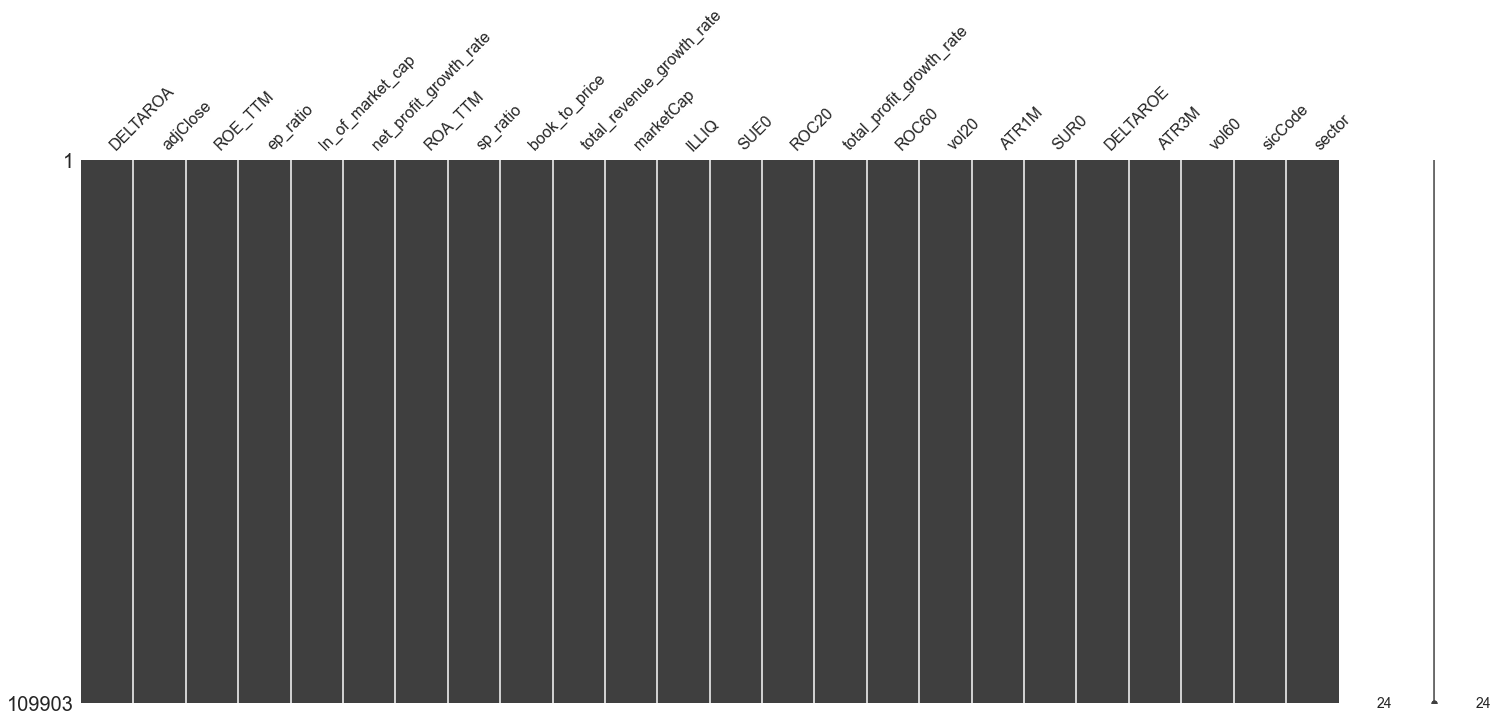

In [790]:
import missingno as msno
msno.matrix(_df)

## Remove highly-correlated factors

/opt/anaconda3/envs/quant/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


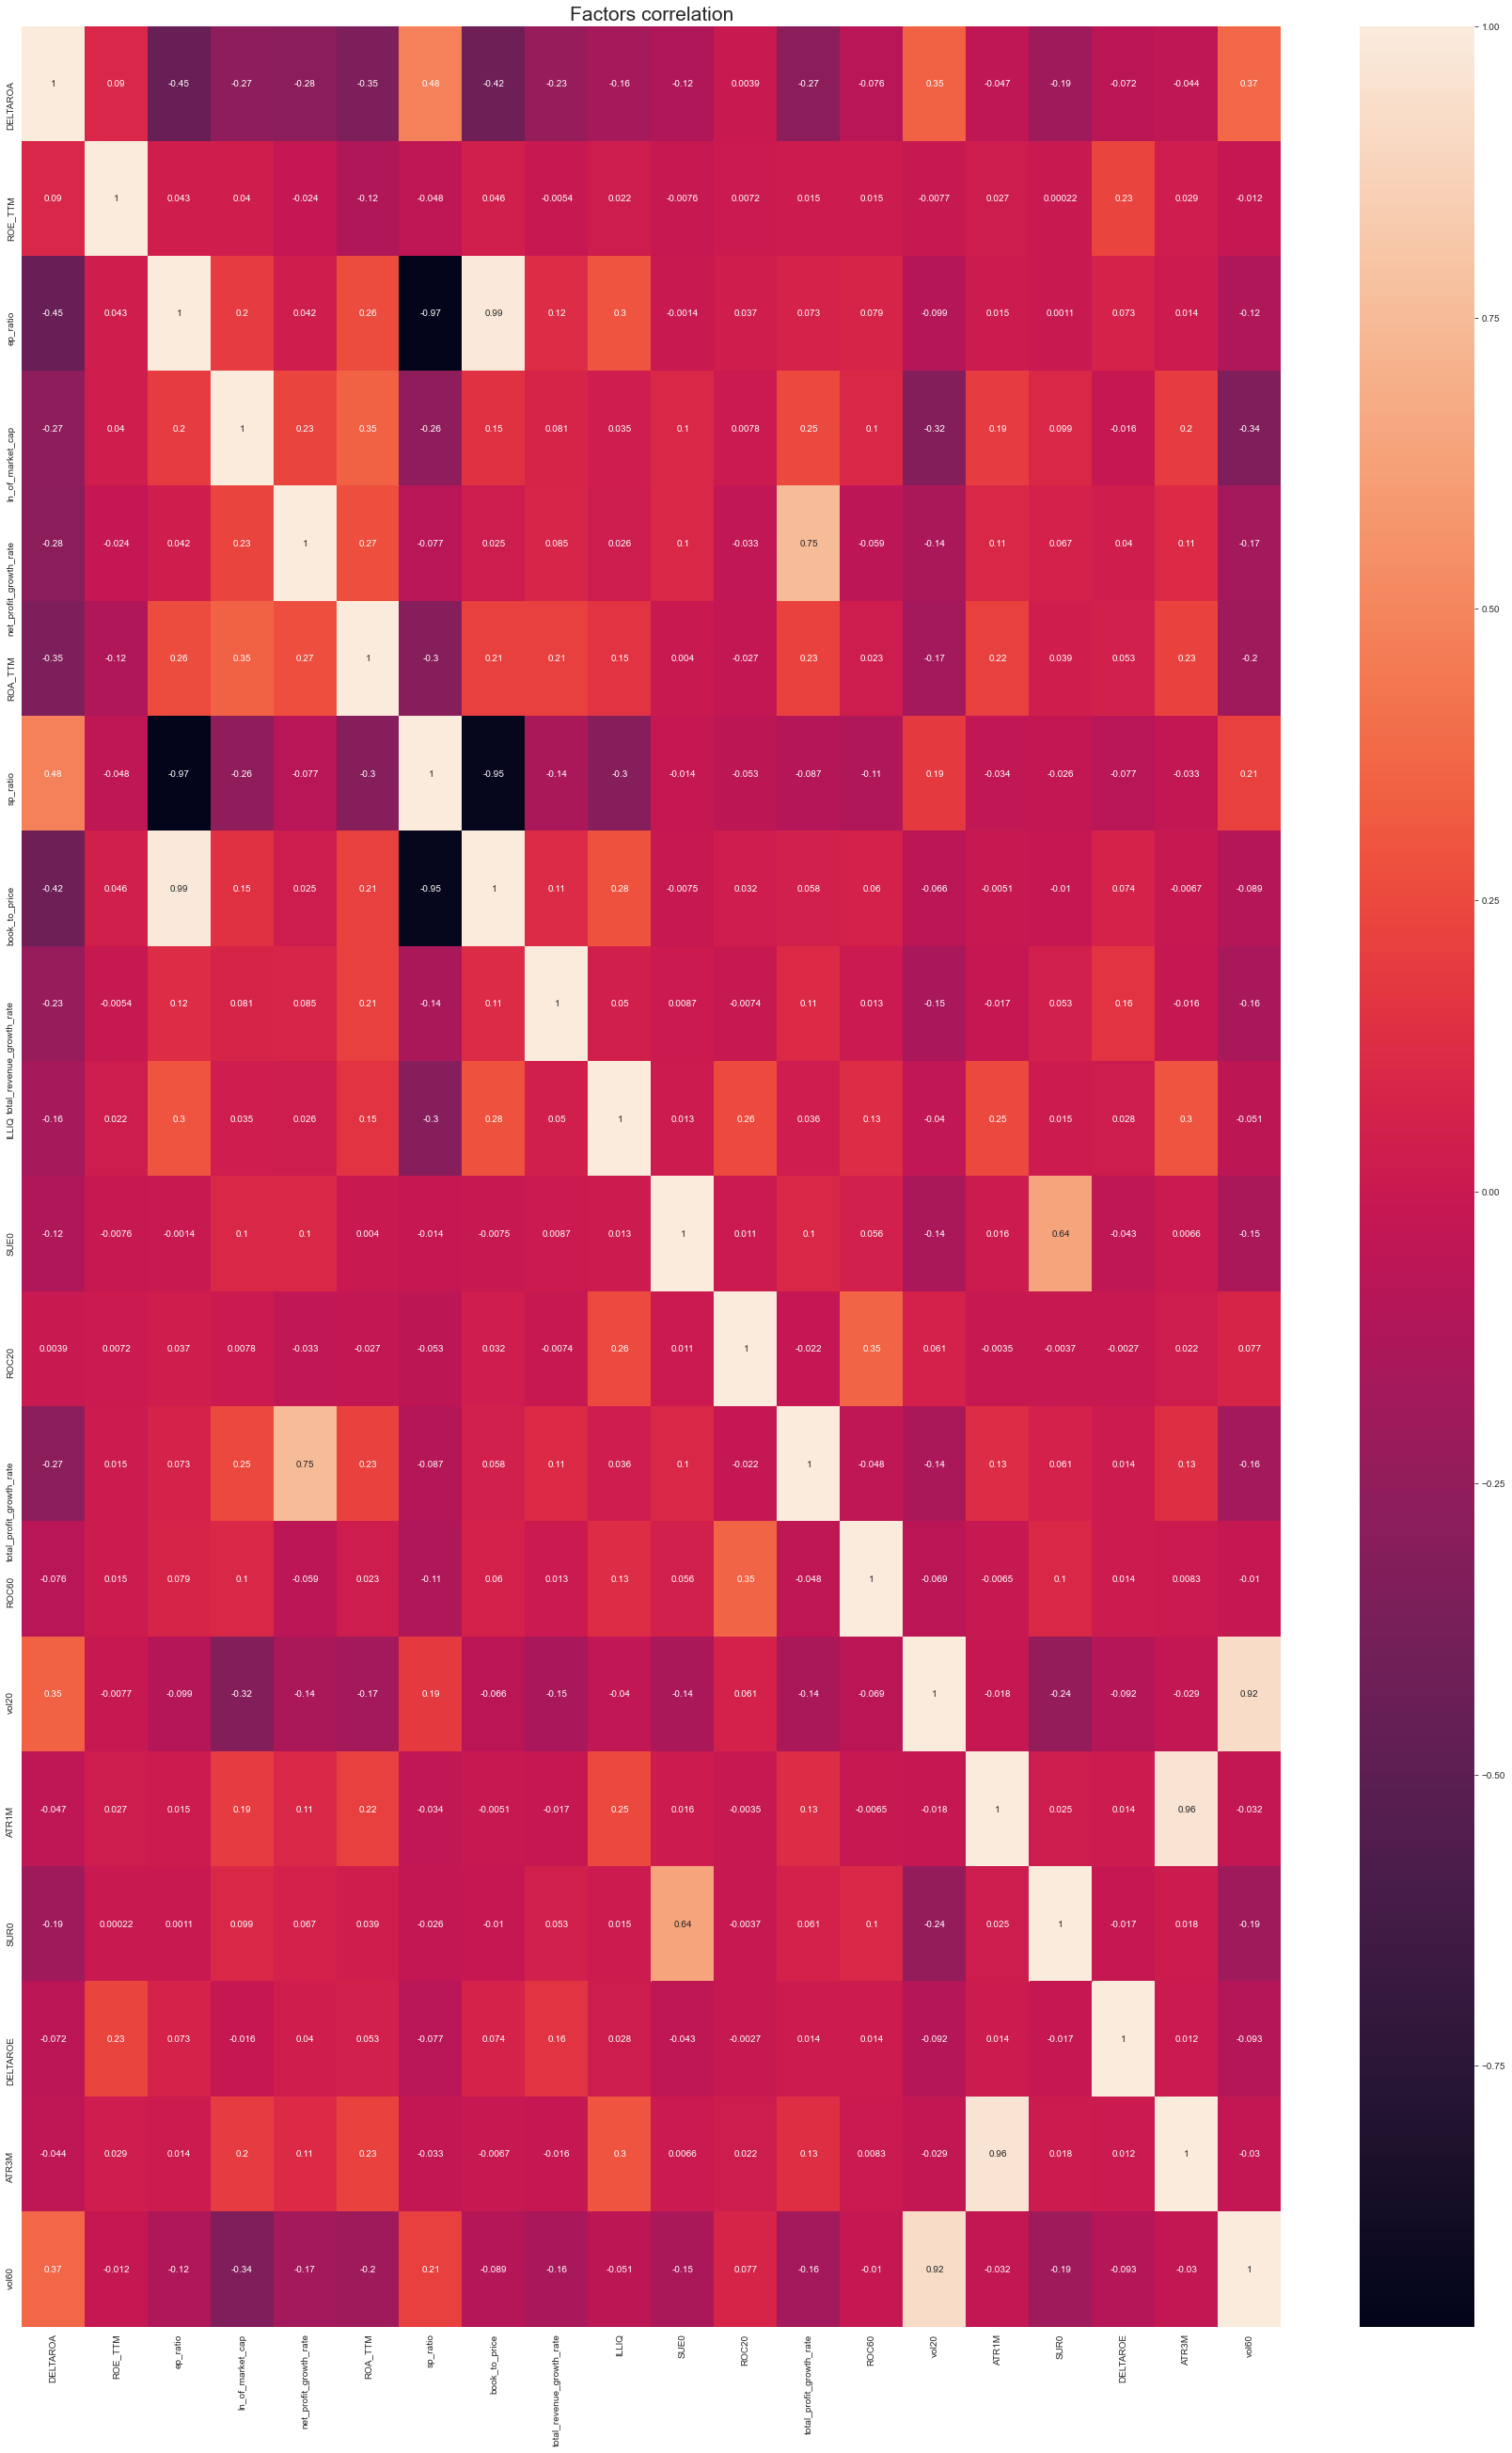

In [791]:
fig = plt.figure(figsize=(30,45))
ax = fig.add_subplot(111)
sns.heatmap(_df[factor_names].corr(), annot=True)
ax.set_title("Factors correlation", fontsize=21)
fig.show()

In [792]:
# 移除不想要测的因子名称
feature_names = [n for n in factor_names if n not in REMOVING_FACTORS]

## Process Extream Value

### Winsorize (缩尾处理) <font color='red'> (Optional)</font>

https://zhuanlan.zhihu.com/p/139475782

### 去极值
[Median Absolute Deviation 绝对中位数法](https://blog.csdn.net/horses/article/details/78749485)
<br>
<details>
    <summary>More details</summary>
    <figure>
    我们采用MAD（Median Absolute Deviation 绝对中位数法）去极值，对于极值部分将其均匀插值到 3-3.5 倍绝对中位数范围内。具体操作如下，首先计算当期所有股 票在因子f上的中位数 mf ，然后计算绝对中位数

    $𝑀𝐴𝐷=𝑚𝑒𝑑𝑖𝑎𝑛(|𝑓−𝑚𝑓|)$

    采用与 3σ 法等价的方法，保留  $[𝑚𝑓−3∙1.483∙𝑀𝐴𝐷，𝑚𝑓+3∙1.483∙𝑀𝐴𝐷]$  之间股票的因子值不变，取值大于  𝑚𝑓  + 3 ∙ 1.483 ∙ 𝑀𝐴𝐷 的所有股票的因子取值按排序均匀压缩到  [𝑚𝑓+3∙1.483∙𝑀𝐴𝐷,𝑚𝑓+3.5∙1.483∙𝑀𝐴𝐷]  之间，取值低于 mf  − 3 ∙ 1.483 ∙ 𝑀𝐴𝐷 的所 有股票的因子取值按排序均匀压缩到 [𝑚𝑓−3.5∙1.483∙𝑀𝐴𝐷,𝑚𝑓−3∙1.483∙𝑀𝐴𝐷] 之间，这样去除了极值同时也在极值的股票之间保序。
    </figure>
</details>


In [793]:
# 获取中位数
median = _df[feature_names].median(axis=0)

# 按列索引匹配，并在行中广播
MAD = abs(_df[feature_names].sub(median, axis=1)).median(axis=0)

MAD_THRESHOLD = 5
# 利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
_df.loc[:, feature_names] = _df.loc[:, feature_names].clip(
    lower=(median-MAD_THRESHOLD*1.4826*MAD), 
    upper=(median+MAD_THRESHOLD*1.4826*MAD), 
    axis=1
)

## Neutralization

In [794]:
# 回归取残差
def calc_resid(x: pd.DataFrame, y: pd.Series) -> float:
    result = sm.OLS(y, x).fit()
    return result.resid

In [795]:
X = pd.get_dummies(_df['sector'])
X['marketCap'] = np.log(_df['marketCap'])

neutralized_df = pd.concat([calc_resid(X.fillna(0), _df[i]) for i in feature_names], axis=1)
neutralized_df.columns = feature_names

neutralized_df['sicCode'] = _df['sicCode']
neutralized_df['sector'] = _df['sector']
neutralized_df['marketCap'] = _df['marketCap']
neutralized_df['adjClose'] = _df['adjClose']

## Standardization

In [796]:
neutralized_df.loc[:, feature_names] = (neutralized_df.loc[:, feature_names] - neutralized_df.loc[:, feature_names].mean()) / neutralized_df.loc[:, feature_names].std()

## Orthogonalization 
- [因子多重共线性的处理](https://www.joinquant.com/view/community/detail/8c60c343407d41b09def615c52c8693d?type=1#%E5%9B%9B%E3%80%81%E5%9B%A0%E5%AD%90%E5%A4%9A%E9%87%8D%E5%85%B1%E7%BA%BF%E6%80%A7%E7%9A%84%E5%A4%84%E7%90%86)
- [因子正交的理论和说明](https://www.sohu.com/a/201668064_619347)

In [797]:
## 构建对称正交变换函数
def lowdin_orthogonal(data:pd.DataFrame)->pd.DataFrame:

    data_ = data.copy(deep=True) # 创建副本不影响原数据
    cols = data_.columns
    
    F = np.mat(data_)  # 除去行业指标,将数据框转化为矩阵
    M = F.T @ F # 等价于 (F.shape[0] - 1) * np.cov(F.T)
    a,U = np.linalg.eig(M)  # a为特征值，U为特征向量
    D_inv = np.linalg.inv(np.diag(a))
    S = np.real(U @ np.sqrt(D_inv) @ U.T)
    data_[cols] = data_.dot(S)
    
    return data_

In [798]:
# 假如 by date数据太少，就无法做正交
N = 200
neutralized_df = neutralized_df.dropna().groupby(level='date').filter(lambda x: len(x) > N)

In [799]:
#对称正交化
orthogonalized_df = neutralized_df[feature_names].groupby(level='date').apply(lowdin_orthogonal) 

orthogonalized_df['sicCode'] = neutralized_df['sicCode']
orthogonalized_df['sector'] = neutralized_df['sector']
orthogonalized_df['marketCap'] = neutralized_df['marketCap']
orthogonalized_df['adjClose'] = neutralized_df['adjClose']

orthogonalized_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 107424 entries, ('2020-03-31 00:00:00+00:00', 'a') to ('2021-01-20 00:00:00+00:00', 'zts')
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ep_ratio                107424 non-null  float64
 1   net_profit_growth_rate  107424 non-null  float64
 2   book_to_price           107424 non-null  float64
 3   vol20                   107424 non-null  float64
 4   SUR0                    107424 non-null  float64
 5   ATR3M                   107424 non-null  float64
 6   vol60                   107424 non-null  float64
 7   sicCode                 107424 non-null  int64  
 8   sector                  107424 non-null  object 
 9   marketCap               107424 non-null  float64
 10  adjClose                107424 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 9.4+ MB


In [800]:
#构建计算横截面因子载荷相关系数均值函数
def get_relations(datas: pd.DataFrame) -> pd.DataFrame:
    relations = 0

    for trade,d in datas.groupby(level='date'):
        relations += d.corr()

    relations_mean = relations / len(datas.index.levels[0])

    return relations_mean

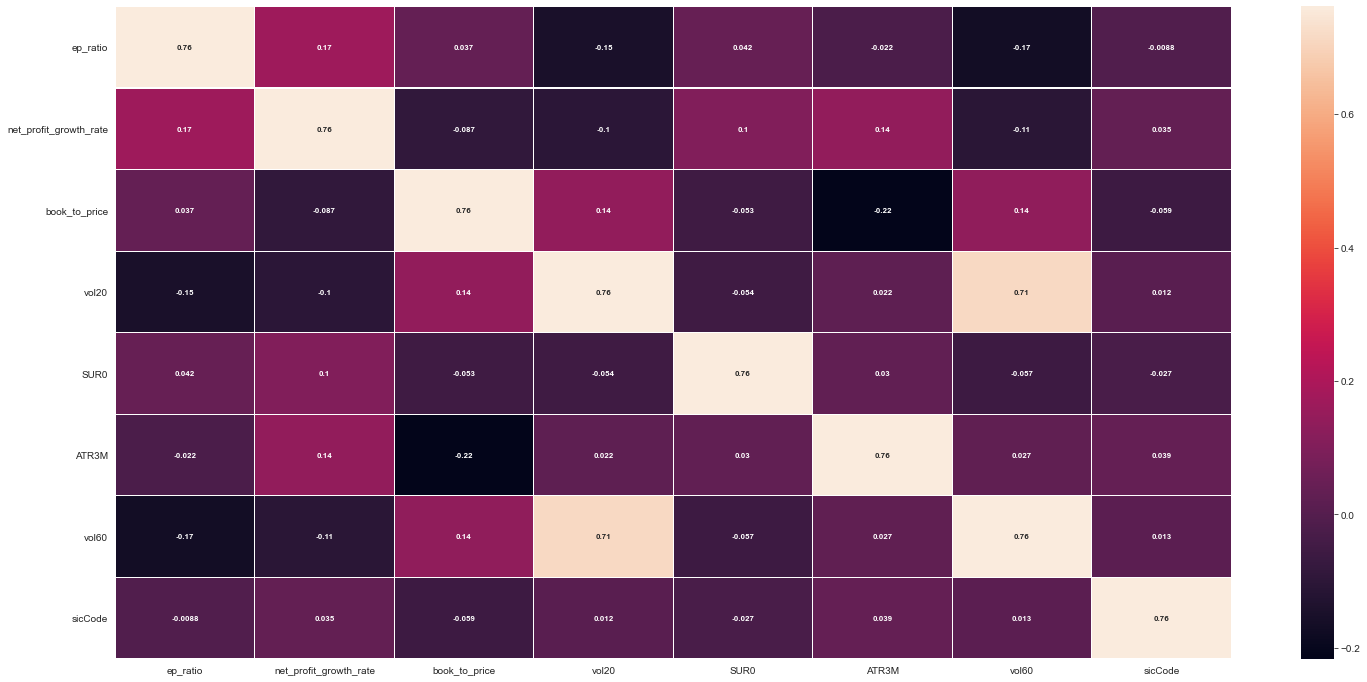

In [801]:
# 绘制因子正交前的相关性的热力图
fig = plt.figure(figsize=(25, 12))
# 计算对称正交之前的相关系数矩阵
relations = get_relations(neutralized_df.iloc[:,:-2])  
sns.heatmap(relations, annot=True, linewidths=0.05,
            linecolor='white', annot_kws={'size': 8, 'weight': 'bold'})

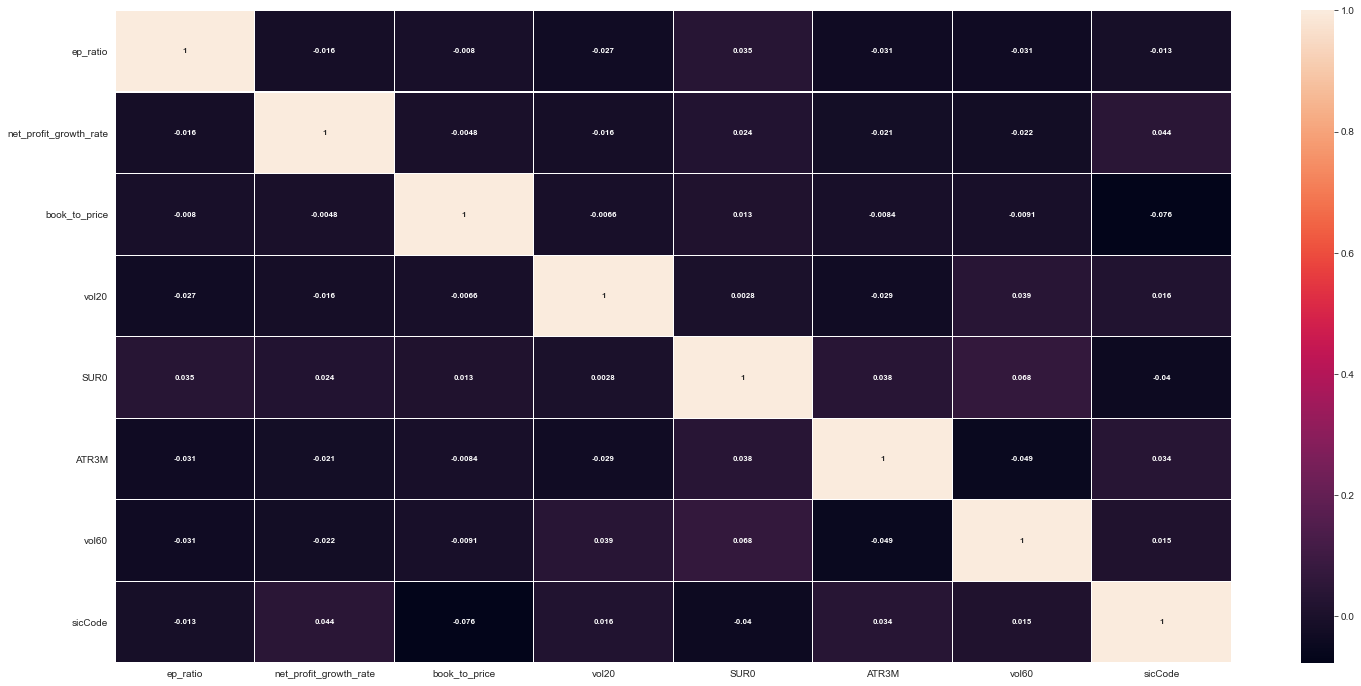

In [802]:
#绘制因子正交后的相关性热力图
fig=plt.figure(figsize=(25,12))
#计算对称正交之后的相关系数矩阵
relations= get_relations(orthogonalized_df.iloc[:,:-2])  
sns.heatmap(relations,annot=True,linewidths=0.05,
            linecolor='white',annot_kws={'size':8,'weight':'bold'})

---

# Scoring the stocks

1. Test factors that has no processed
2. Test factors that has been standardized
3. Test factors that has been neutralized
4. Test factors that has been orthogonalized

## Calculate daily return

In [803]:
if USE_ORTHOGONAL_DATA:
    prepared_df = orthogonalized_df.copy(deep=True)
else:
    prepared_df = neutralized_df.copy(deep=True)

rtn = prepared_df.reset_index()
rtn = pd.pivot(rtn[['date', 'ticker', 'adjClose']], index='date', columns='ticker', values='adjClose')
if FREQ == 'daily':
    rtn = rtn.pct_change()
elif FREQ == 'weekly':
    rtn = rtn.pct_change(5)
elif FREQ == 'monthly':
    rtn = rtn.pct_change(22)
else:
    raise(Exception('Frequency not setting up'))
rtn = rtn.iloc[:-1]
rtn = rtn.stack()
prepared_df['rtn'] = rtn
prepared_df['log_rtn'] = np.log(1 + rtn)

# Get industry weight
prepared_df['capWeight'] = prepared_df.groupby('date')['marketCap'].apply(lambda x:x/x.sum())
prepared_df['weighted_rtn'] = prepared_df['capWeight'] * prepared_df['log_rtn']

prepared_df.to_csv('/Users/michael/Desktop/prepared_data.csv')

In [804]:
prepared_df = pd.read_csv('/Users/michael/Desktop/prepared_data.csv').sort_values(['date', 'ticker'])
prepared_df['date'] = pd.to_datetime(prepared_df['date'])
prepared_df.set_index(['date', 'ticker'], inplace=True)

## Calculate factor weights in order to calculate final score
We are going to implement three different ways to calculate the weight of factors, in order to calculate our final score:
1. IC weighted
2. IR weighted
3. Equal weighted

In [805]:
# Required number of sample data per day
N = 200
prepared_df = prepared_df.dropna().groupby(level='date').filter(lambda x: len(x) > N)

### Using IC to calculate the weights for scoring

**Performance: Sharpe Ratio / Information Ratio (IC)**

It cannot be judged whether the factor just from return. The return should be sufficient considering the risks taken; in other words, sharpe ratio should be around 1.5 to 2.0. Less than 1.0 is not good but also better to investigate if sharpe ratio is too good. IC = Sharpe Ratio for the market and common factor neutral portfolio, and our objective is to maximise Information Ratio (IR) = IC x sqrt(B) where B is breadth, the number of independent bets, so seeking for a good Sharpe Ratio is crucial.

If the sample size is not large enough, you could get IC = 0

```python
x = pd.Series([-1.2663669082345000,-0.06910153794444630,-1.5083478909829400,-0.16755316023549200,-0.7665562463996680,-0.16649428121783800,0.19339676302357200])
y = pd.Series([0.007188231361294320,0.01427389325500020,0.004038257172643170,0.011834319525964300,-0.0018585790319958200,-0.01242347857338340,0.0010996171703268100])

stats.spearmanr(x,y,nan_policy='omit')
>> SpearmanrResult(correlation=0.0, pvalue=1.0)
```

#### Calculate IC / Rank IC
**Calculate Spearman IC**

[百度百科](https://baike.baidu.com/item/spearman%E7%9B%B8%E5%85%B3%E7%B3%BB%E6%95%B0/7977847?fr=aladdin)

In [806]:
IC = prepared_df.groupby(level='date').apply(
    lambda x: [stats.spearmanr(x[factor], x['rtn'], nan_policy='omit')[0] for factor in feature_names]
)

IC_Rank = prepared_df.groupby(level='date').apply(
    lambda x: [stats.spearmanr(x[factor].rank(), x['rtn'].rank(), nan_policy='omit')[0] for factor in feature_names]
)

# 计算ic值，得到ic的
IC = pd.DataFrame(IC.tolist(), index=IC.index, columns=feature_names)
IC_Rank = pd.DataFrame(IC_Rank.tolist(), index=IC_Rank.index, columns=feature_names)

#### Calculate weights

In [807]:
# 计算IR权重,按行求和,按列相除
IC_abs = IC.abs()
IC_weights = IC_abs.div(IC_abs.sum(axis=1), axis=0)

### Using IR to calculate the weights for scoring

#### Calculate IR / Rank IR

In [808]:
######## 计算Normal IR ########
# rolling为移动窗口函数,滚动12个月
rolling_ic = IC.rolling(12, min_periods=1).mean()

# 当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替
rolling_ic_std = IC.rolling(12, min_periods=1).std()

# 计算IR值
IR = rolling_ic / rolling_ic_std
IR.iloc[0,:] = rolling_ic.iloc[0,:]

######## 计算Rank IR ########
# rolling为移动窗口函数,滚动12个月
rolling_ic_rank = IC_Rank.rolling(12, min_periods=1).mean()

# 当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替
rolling_ic_rank_std = IC_Rank.rolling(12, min_periods=1).std()

# 计算IR值
IR_Rank = rolling_ic_rank / rolling_ic_rank_std
IR_Rank.iloc[0,:] = rolling_ic_rank.iloc[0,:]

#### IC/IR table analysis

/opt/anaconda3/envs/quant/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


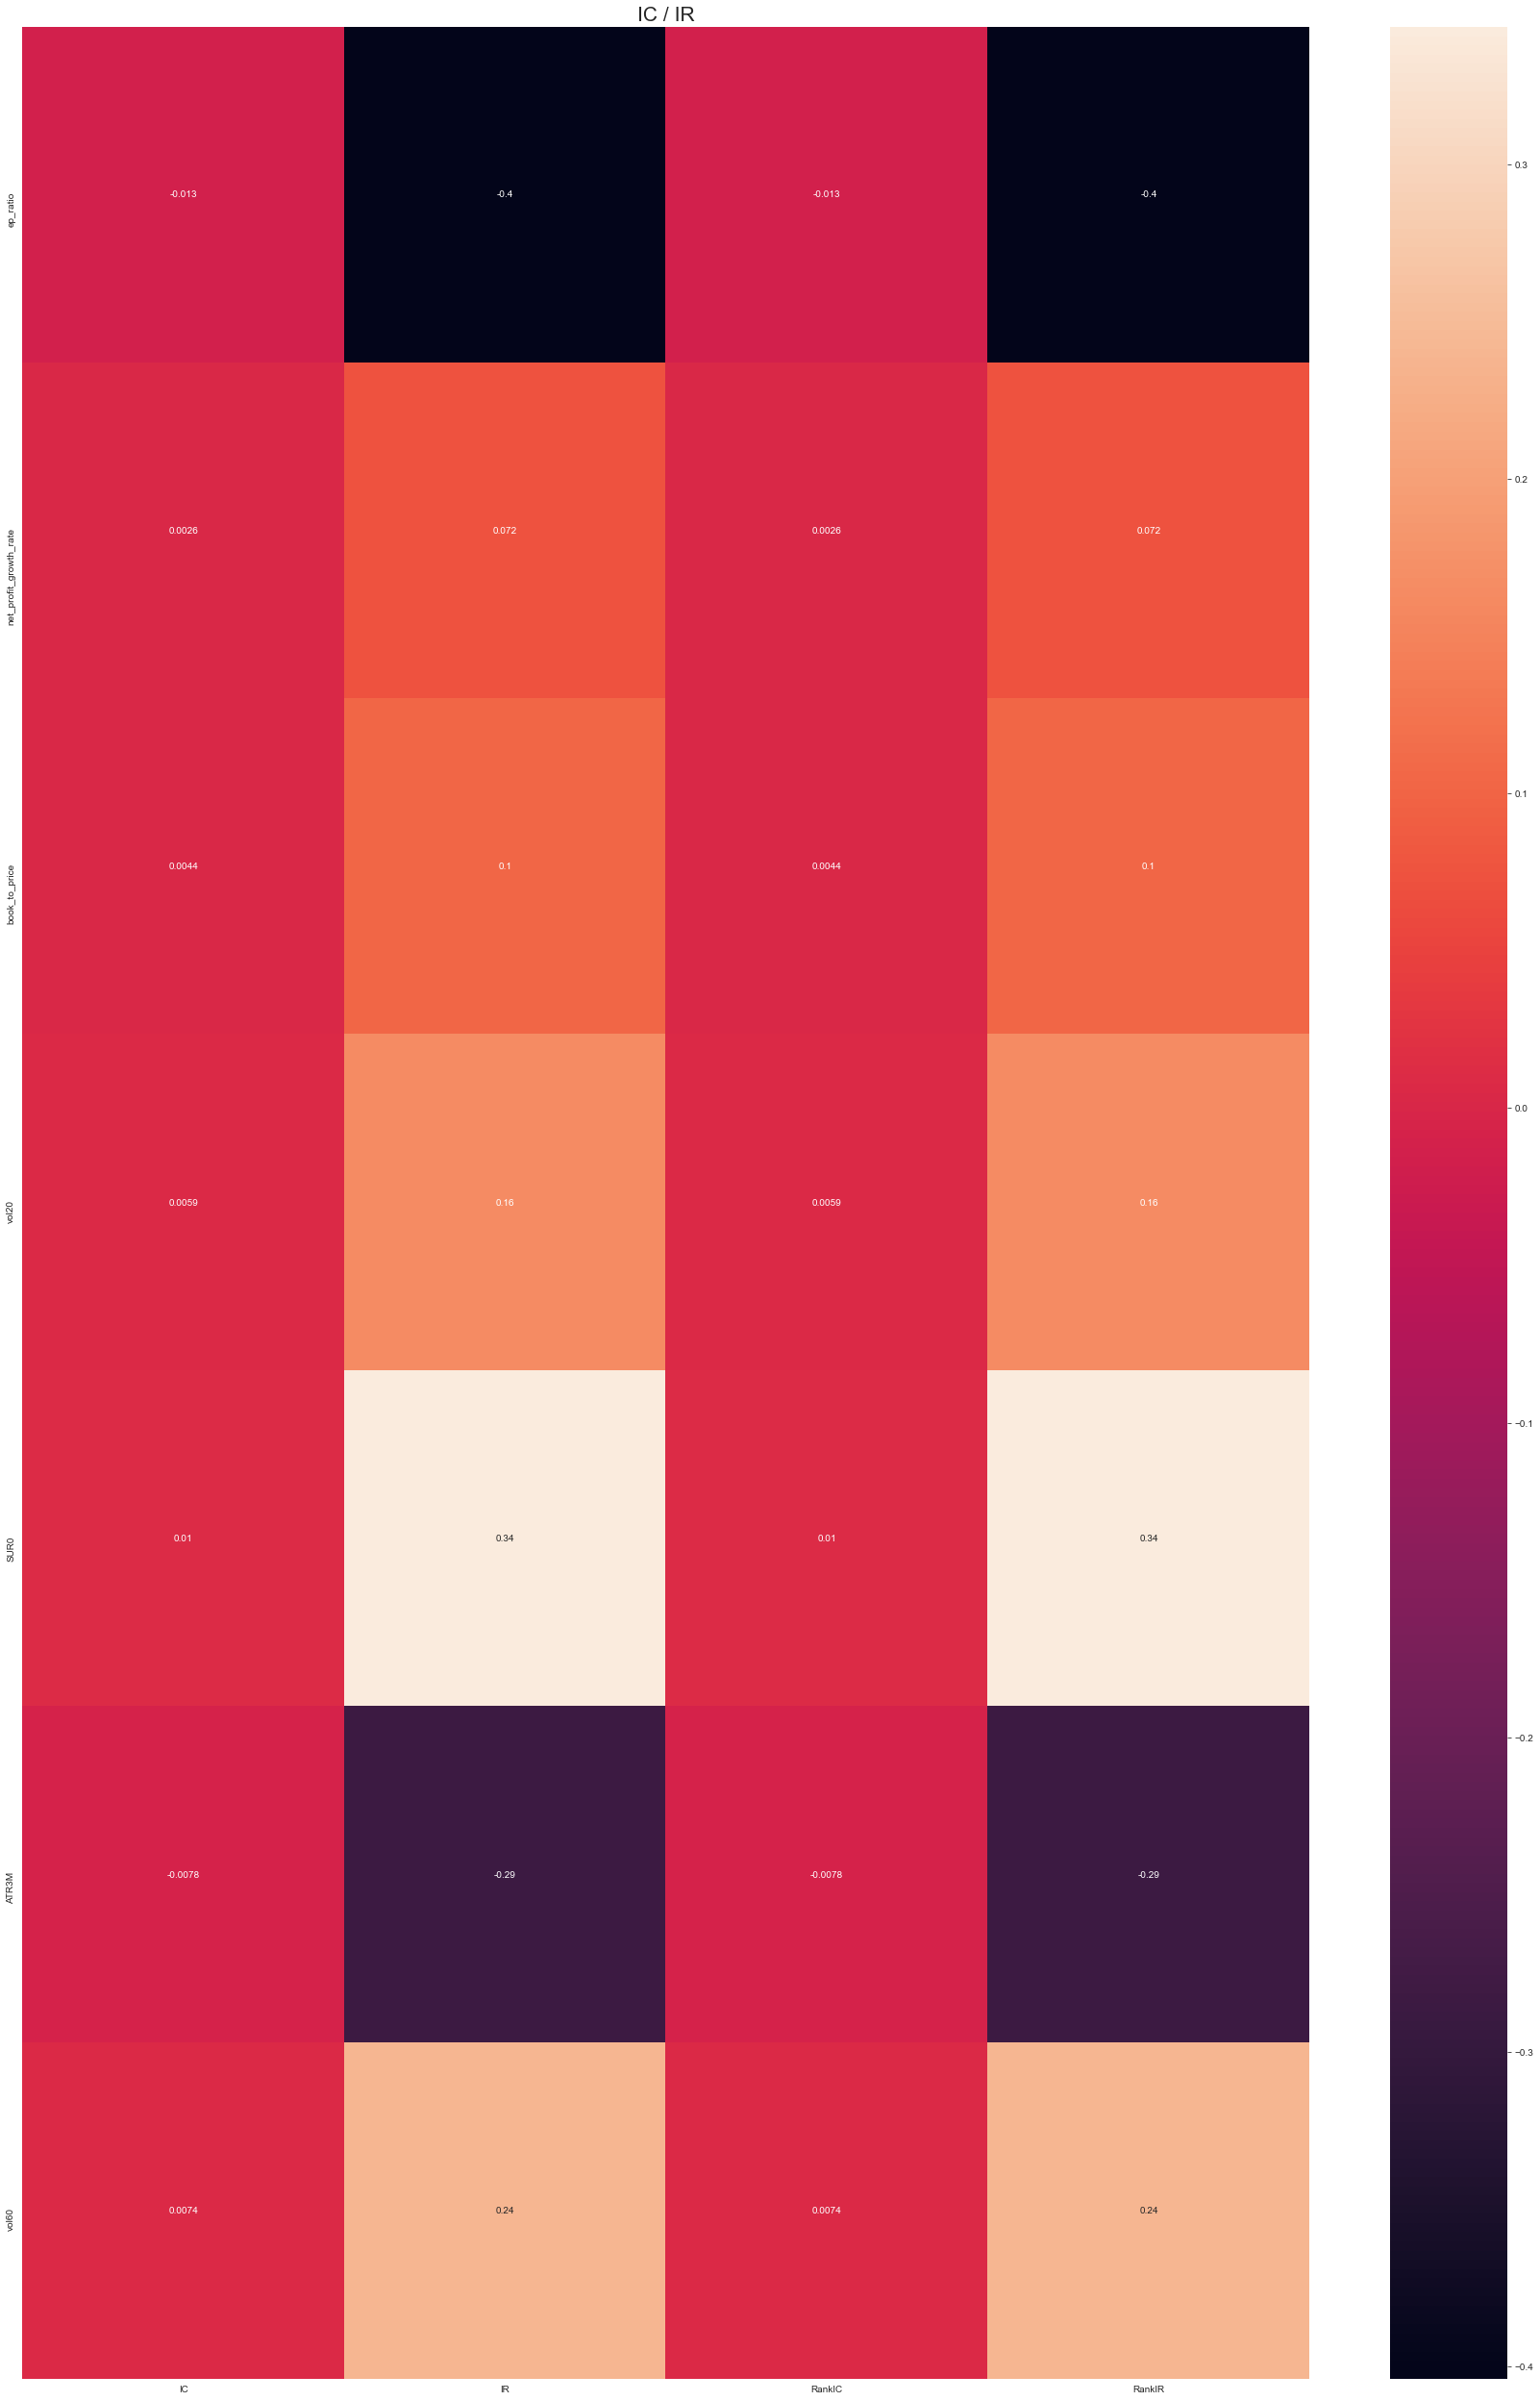

In [809]:
# 因子 IC 分析
# IndexList = feature_names
ColumnsList = ["IC", "IR", "RankIC", "RankIR"]
IC_analysis = pd.DataFrame(columns=ColumnsList)


for factor in feature_names:
    IC_analysis.loc[factor, 'IC'] = rolling_ic[factor].mean()
    IC_analysis.loc[factor, 'IR'] = rolling_ic[factor].mean() / rolling_ic[factor].std()
    IC_analysis.loc[factor, 'RankIC'] = rolling_ic_rank[factor].mean()
    IC_analysis.loc[factor, 'RankIR'] = rolling_ic_rank[factor].mean() / rolling_ic_rank[factor].std()
    
IC_analysis = IC_analysis.astype(float)

fig = plt.figure(figsize=(30,45))
ax = fig.add_subplot(111)
# sns.heatmap(IC_analysis, annot=True, vmax=1, vmin=0)
sns.heatmap(IC_analysis, annot=True)
ax.set_title("IC / IR", fontsize=21)
fig.show()

#### Calculate weights

A股不能做空 所以要取绝对值（不然后面权重计算会有问题） 其次时IC代表的是相关性 正负只是方向 所以有时候看abs（ic） 大于一定的阈值就可以确定ic的有效性了

In [810]:
IC = prepared_df.groupby(level='date').apply(
    lambda x: [stats.spearmanr(x[factor], x['rtn'], nan_policy='omit')[0] for factor in feature_names]
)

# 计算ic值，得到ic的
IC = pd.DataFrame(IC.tolist(), index=IC.index, columns=feature_names)

# 计算IC的绝对值
IC_abs = IC.abs()

# rolling为移动窗口函数,滚动12个月
rolling_ic = IC_abs.rolling(12, min_periods=1).mean()

# 当滚动计算标准差时，起始日期得到的是缺失值，所以算完权重后，起始日期的值任用原值IC代替
rolling_ic_std = IC_abs.rolling(12, min_periods=1).std()

# 计算IR值
IR = rolling_ic / rolling_ic_std
IR.iloc[0,:] = rolling_ic.iloc[0,:]

In [811]:
# 计算IR权重,按行求和,按列相除
IR_weights = IR.div(IR.sum(axis=1), axis=0)
IC_weights = IC_abs.div(IC_abs.sum(axis=1), axis=0)

### Using average weights for each factors

Simply add up all the factors, so no need further processing

## Scores

### Calculate scores
`factors5['SCORE'] = (factors5[factor_names].mul(weights)).sum(axis=1)`

> PS: 这里计算分数时：是用的当期因子值乘以当期weights，我觉得应该是当期因子值乘以上一期的weights吧？ 因为计算当期weights时，需要先计算IC值，计算IC值时用到了一个月后的收益率，所以为了避免未来数据，应该是当期因子值乘以上一期的weights

In [812]:
# 计算因子分数
if FACTOR_WEIGHT_METHOD == 'IC':
    prepared_df['SCORE'] = (prepared_df[feature_names].mul(IC_weights)).sum(axis=1)
elif FACTOR_WEIGHT_METHOD == 'IR':
    prepared_df['SCORE'] = (prepared_df[feature_names].mul(IR_weights)).sum(axis=1)
elif FACTOR_WEIGHT_METHOD == 'EQUAL':
    prepared_df['SCORE'] = prepared_df[feature_names].sum(axis=1)

### Exam the correlation between score and returns

In [813]:
prepared_df[['log_rtn', 'SCORE']].corr('spearman').iloc[1,0]

0.016880820251282104

### Accumulate returns by score groups

In [814]:
if FREQ == 'daily':
    pass
elif FREQ == 'weekly':
    idx = [d for d in exam_df.index if d.isoweekday() == 1]
    prepared_df = prepared_df.loc[idx, :]
elif FREQ == 'monthly':
    idx = [d for d in exam_df.index if d.day == 1]
    prepared_df = prepared_df.loc[idx, :]
else:
    raise(Exception('Frequency not setting up'))

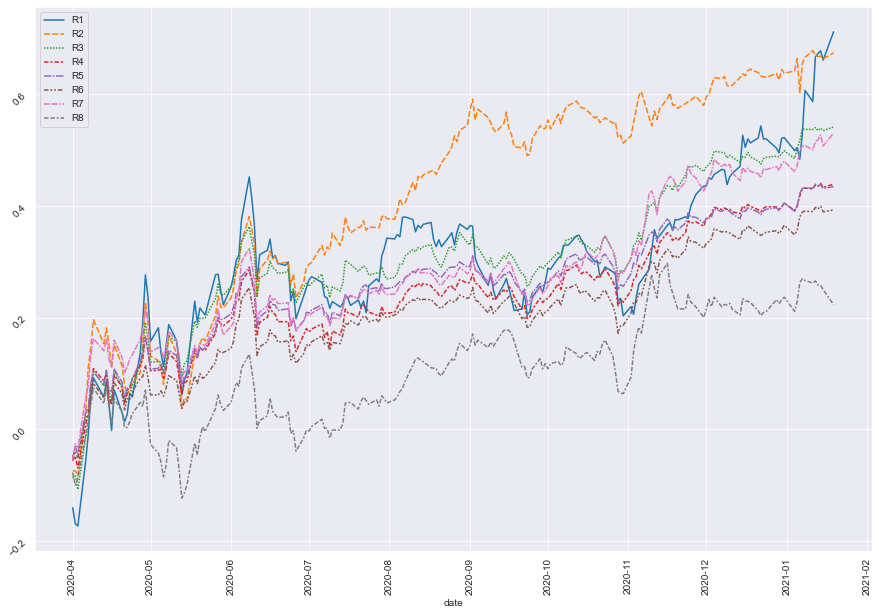

In [815]:
_prepared_df = snp_scaffolding.copy()
_prepared_df['sector'] = prepared_df['sector']
_prepared_df['SCORE'] = prepared_df['SCORE']
_prepared_df['log_rtn'] = prepared_df['log_rtn']
_prepared_df.dropna(inplace=True)
_prepared_df.index = _prepared_df.index.droplevel(1)
_prepared_df.reset_index().drop(columns='date', inplace=True)

_prepared_df['rate'] = _prepared_df.groupby('date')['SCORE'].apply(lambda x : pd.cut(x, bins=8, labels=['R8', 'R7', 'R6','R5','R4','R3','R2','R1']))
x = _prepared_df.groupby(['date', 'rate'])['log_rtn'].apply(lambda x: x.sum()/len(x)).reset_index().set_index(['rate', 'date'])
z = pd.DataFrame(index=x.loc['R1'].index)
    
for i in range(1,9):
    z[f'R{i}'] = x.loc[f'R{i}',:].cumsum()
    
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.yticks(rotation=45)

sns.lineplot(data=z)

# Performance Analysis

**Methodology Instruction**

策略步骤：
1. step1:将基准指数成份股按以上行业划分成34个子集，在每个子集中用市值因子将股票划分为数目相等的三组； *(Use sector instead of sicCode as industry category as the number of sicCode is more than 100 and the number of sector is only 14. So use sector would better off constructing your portfolio category)*
2. step2:计算每个小组内所有股票在基准指数中的总权重；
3. step3:在每个小组中选择预期收益（打分法）最高的一只股票，令它在投资组合中的权重等于它所处小组的权重。这样就能选出包含102只股票的分层抽样组合。

## Implementation

### Get Group

In [816]:
def get_group(ser:pd.Series,N:int=3,ascend:bool=True)->pd.Series:
    '''默认分三组 升序'''
    ranks = ser.rank(ascending=ascend)
    label = ['G'+str(i) for i in range(1,N + 1)]
    
    return pd.cut(ranks,bins=N,labels=label) 

In [817]:
group_c = [
    pd.Grouper(level='date'),
    pd.Grouper(key='sector')
]

prepared_df['group'] = prepared_df.groupby(group_c)['capWeight'].apply(lambda x:get_group(x, 3))

In [818]:
prepared_df

ep_ratio  net_profit_growth_rate  \
date                      ticker                                     
2020-04-01 00:00:00+00:00 a       0.097722               -0.156480   
                          aal    -2.594680                0.282388   
                          aapl    0.117070               -0.687586   
                          abbv    0.826809               -0.353067   
                          abc     1.094881               -0.261589   
...                                    ...                     ...   
2021-01-19 00:00:00+00:00 yum     0.093869                0.185019   
                          zbh    -0.663756               -1.095706   
                          zbra   -0.220726               -0.729220   
                          zion   -0.395150               -0.929593   
                          zts    -0.241958               -0.020658   

                                  book_to_price     vol20      SUR0     ATR3M  \
date                      ticker                                                
2020-04-01 00:00:00+00:00 a           -0.238791  0.402161 -1.845992 -0.757258   
                          aal         -2.517175  2.642449 -2.494888 -0.403455   
                          aapl         0.578991  2.592983 -0.273688 -1.595549   
                          abbv        -0.503500  1.326328 -0.033373 -1.099478   
                          abc         -0.330389  0.796978  0.875392 -0.362812   
...                                         ...       ...       ...       ...   
2021-01-19 00:00:00+00:00 yum         -1.385945 -1.211324  1.297215 -0.753798   
                          zbh          0.239633 -0.443115  0.181526 -0.466294   
                          zbra        -0.471994 -0.825836 -0.424514  2.018508   
                          zion        -0.258983 -0.348330  0.493986 -0.308033   
                          zts         -0.304645 -0.358761  0.154401 -0.912736   

                                     vol60  sicCode              sector  \
date                      ticker                                          
2020-04-01 00:00:00+00:00 a      -0.104870     3826          Healthcare   
                          aal     2.707471     4512         Industrials   
                          aapl    1.701977     3571          Technology   
                          abbv    0.687176     2834          Healthcare   
                          abc     0.066077     5122          Healthcare   
...                                    ...      ...                 ...   
2021-01-19 00:00:00+00:00 yum    -1.344701     5812   Consumer Cyclical   
                          zbh    -0.400095     3842          Healthcare   
                          zbra   -0.862959     3560          Technology   
                          zion    0.306402     6021  Financial Services   
                          zts    -0.373061     2834          Healthcare   

                                     marketCap    adjClose       rtn  \
date                      ticker                                       
2020-04-01 00:00:00+00:00 a       2.122544e+10   68.546241 -0.037699   
                          aal     4.554568e+09   10.690000 -0.123052   
                          aapl    1.047572e+12   59.854674 -0.052617   
                          abbv    1.043679e+11   69.746830 -0.036356   
                          abc     1.752496e+10   85.117344 -0.025650   
...                                        ...         ...       ...   
2021-01-19 00:00:00+00:00 yum     3.239614e+10  107.390000  0.007222   
                          zbh     3.315003e+10  159.930000 -0.001187   
                          zbra    2.163793e+10  405.840000 -0.008260   
                          zion    8.090692e+09   49.330000  0.003867   
                          zts     7.726429e+10  162.570000  0.007799   

                                   log_rtn  capWeight  weighted_rtn     SCORE  \
date                      ticker                                           

### Get stock that score highest in each group

In [819]:
portfolio = snp_scaffolding.copy()
portfolio['sector'] = prepared_df['sector']
portfolio['SCORE'] = prepared_df['SCORE']
portfolio['log_rtn'] = prepared_df['log_rtn']
portfolio['group'] = prepared_df['group']
portfolio.dropna(inplace=True)

group_c2 = [
    pd.Grouper(level='date'),
    pd.Grouper(key='sector'),
    pd.Grouper(key='group')
]

portfolio = portfolio.groupby(group_c2)['SCORE'].apply(lambda x: x.idxmax()[1])

In [820]:
portfolio

date                       sector                  group
2020-04-01 00:00:00+00:00  Basic Materials         G1        emn
                                                   G2        lyb
                                                   G3        nem
                           Communication Services  G1       lumn
                                                   G2          t
                                                            ... 
2021-01-19 00:00:00+00:00  Technology              G2       etsy
                                                   G3        amd
                           Utilities               G1        pnw
                                                   G2        dte
                                                   G3        sre
Name: SCORE, Length: 6666, dtype: object

In [821]:
# 格式调整
portfolio = portfolio.reset_index()
portfolio = portfolio.set_index(['date', 'SCORE'])
portfolio.index.names = ['date', 'ticker']
portfolio['score'] = prepared_df['SCORE']

In [822]:
# 加入权重
portfolio['weight'] = prepared_df['capWeight']

# 令权重加总为1
portfolio['w'] = portfolio.groupby(
    level='date'
)['weight'].transform(
    lambda x: x / x.sum()
)

In [823]:
portfolio['rtn'] = prepared_df['rtn']
portfolio['log_rtn'] = prepared_df['log_rtn']
portfolio['weighted_rtn'] = portfolio['w'] * portfolio['log_rtn']

In [824]:
portfolio.to_csv('/Users/michael/Desktop/portfolio.csv')

In [825]:
portfolio

sector group     score  \
date                      ticker                                           
2020-04-01 00:00:00+00:00 emn            Basic Materials    G1  0.947697   
                          lyb            Basic Materials    G2  0.647679   
                          nem            Basic Materials    G3  0.925086   
                          lumn    Communication Services    G1  0.837884   
                          t       Communication Services    G2  0.416904   
...                                                  ...   ...       ...   
2021-01-19 00:00:00+00:00 etsy                Technology    G2  1.286404   
                          amd                 Technology    G3  0.948124   
                          pnw                  Utilities    G1  0.178816   
                          dte                  Utilities    G2  0.322426   
                          sre                  Utilities    G3  0.201659   

                                    weight         w       rtn   log_rtn  \
date                      ticker                                           
2020-04-01 00:00:00+00:00 emn     0.000284  0.005994 -0.022971 -0.023239   
                          lyb     0.000677  0.014306 -0.092686 -0.097267   
                          nem     0.001737  0.036695  0.026281  0.025942   
                          lumn    0.000419  0.008851 -0.070825 -0.073458   
                          t       0.008807  0.186089 -0.037736 -0.038466   
...                                    ...       ...       ...       ...   
2021-01-19 00:00:00+00:00 etsy    0.000814  0.011175  0.082624  0.079388   
                          amd     0.003140  0.043081  0.014057  0.013959   
                          pnw     0.000256  0.003517 -0.007002 -0.007027   
                          dte     0.000683  0.009369 -0.021373 -0.021605   
                          sre     0.001023  0.014033 -0.005566 -0.005582   

                                  weighted_rtn  
date                      ticker                
2020-04-01 00:00:00+00:00 emn        -0.000139  
                          lyb        -0.001391  
                          nem         0.000952  
                          lumn       -0.000650  
                          t          -0.007158  
...                                        ...  
2021-01-19 00:00:00+00:00 etsy        0.000887  
                          amd         0.000601  
                          pnw        -0.000025  
                          dte        -0.000202  
                          sre        -0.000078  

[6666 rows x 8 columns]

## Results with charts and diagrams

### Histogram of return by groups

In [826]:
x = portfolio.reset_index().groupby(['group', 'date'])['log_rtn'].sum()

z = pd.DataFrame(index=x['G1'].index, columns=['G1', 'G2', 'G3'])
z['G1'] = x['G1'].cumsum()
z['G2'] = x['G2'].cumsum()
z['G3'] = x['G3'].cumsum()

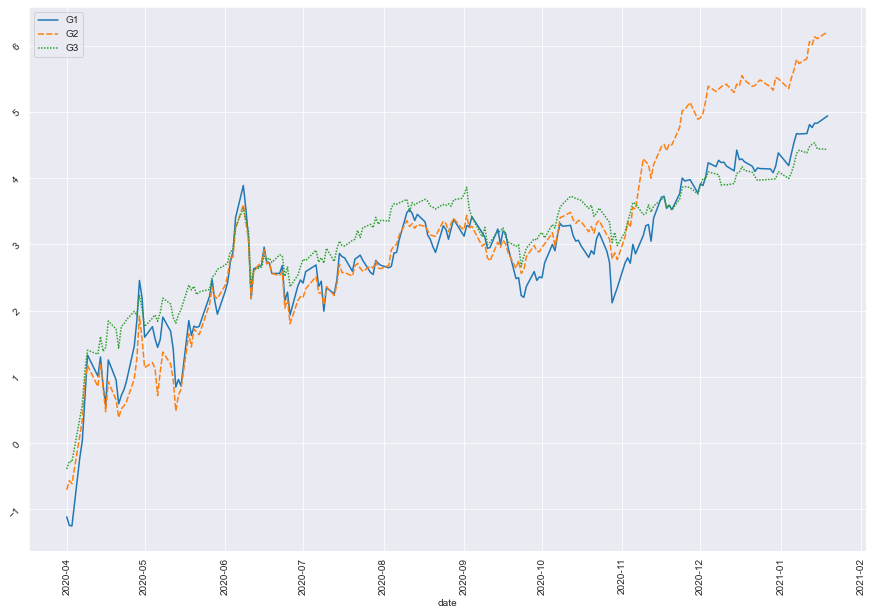

In [827]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.yticks(rotation=45)

sns.lineplot(data=z)

### Performance line chart compared to benchmark

In [828]:
x = portfolio.groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = prepared_df.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T
z['excess_rtn'] = z['portfolio'] - z['benchmark']
z

,portfolio,benchmark,excess_rtn
date,,,
2020-04-01 00:00:00+00:00,-0.039734,-0.044338,0.004604
2020-04-02 00:00:00+00:00,-0.018387,-0.021979,0.003592
2020-04-03 00:00:00+00:00,-0.033313,-0.036181,0.002868
2020-04-06 00:00:00+00:00,0.030402,0.032085,-0.001683
2020-04-07 00:00:00+00:00,0.036899,0.030893,0.006006
...,...,...,...
2021-01-12 00:00:00+00:00,0.483349,0.454828,0.028521
2021-01-13 00:00:00+00:00,0.483401,0.457175,0.026226
2021-01-14 00:00:00+00:00,0.480974,0.453440,0.027535


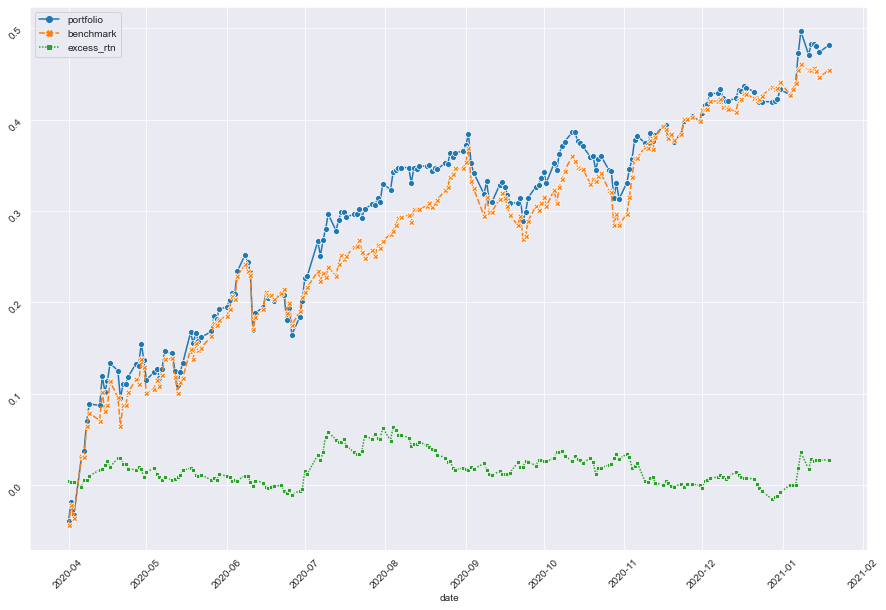

In [829]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
# ax = plt.gca()
# for ind, label in enumerate(ax.xaxis.get_ticklabels()):
#     if ind % 10 == 0:  # every 10th label is kept
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
sns.lineplot(data=z, markers=True)

### Portfolio Variance

In [830]:
ann_factor = 252
variance = z['portfolio'].var() * ann_factor / len(z['portfolio'])

# Show annualized variance
print('Portfolio Variance')
print((variance * 100).round(2), '%')

Portfolio Variance
1.66 %


### Portfolio Sharpe Ratio

In [831]:
# Calculate Sharpe Ratio
ann_factor = 252
sharpe_ratio = np.sqrt(ann_factor) * z['portfolio'].mean() / z['portfolio'].std()
  
# Show Results
print('Sharpe Ratio')
print(sharpe_ratio.round(2))

Sharpe Ratio
40.58


### Portfolio Win Rate

In [832]:
win_rate = len(z[z['excess_rtn'] > 0]['excess_rtn']) / z.shape[0]

# Show Win Rate
print('Win Rate')
print(f'{win_rate*100:.3f} %')

Win Rate
87.624 %


### Alpha and beta

In [833]:
x = portfolio.groupby('date')['rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = prepared_df.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T

In [834]:
_x = z['benchmark']
_X = sm.add_constant(_x)
_y = z['portfolio']

res = sm.OLS(_y, _X).fit()

In [835]:
alpha, beta = res.params
print(f'alpha is {alpha:.3f}')
print(f'beta is {beta:.3f}')

alpha is 1.111
beta is 36.647


---

# Optimization 

## Methodology Instruction

**Objective**
1. Maximize return and tracking an index
2. Decide λ to decide the tradeoff parameter

**Formula**

$x^TPx+\lambda {∥x−q∥}^2$

q = a set of index weights,

λ = a tradeoff parameter

**Constraints**
1. Total weight = 1
2. No short

In [836]:
unoptimize_portfolio = portfolio.copy(deep=True)
# unoptimize_portfolio.reset_index(inplace=True)
# unoptimize_portfolio['date'] = pd.to_datetime(unoptimize_portfolio['date'])
# unoptimize_portfolio.set_index(['date', 'ticker'], inplace=True)

## Optimization

In [139]:
def get_optimized_weight(df:pd.DataFrame, prepared_df):
    df_ = df.copy()
    
    score = df_['score']
    
    length = len(df_)
    
    def func(w):
        trade_off_parameter = 0.8
        
        # Maximizing return
        obj_rtn = w.dot(score)

        # Minimize weight difference between index and portfolio
        portfolio_industry_weight = w.reshape(int(len(w)/3),3).sum(axis=1)
        target_industry_weight = prepared_df.groupby(['date', 'sector'])['capWeight'].sum().loc[df_.index.levels[0][0]]
        
        l2_norm = np.linalg.norm(
            portfolio_industry_weight - target_industry_weight,
            ord=2
        )
        
        return - obj_rtn + (trade_off_parameter * l2_norm)
    
    # Optimization objective
    objective = func
    
    # Constraint to sum of weight should be 1
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Constraint to individual weight not to much deviate
    cons_1 = lambda w: w - df_['w'].values
    nonlinear_constraints = scipy.optimize.NonlinearConstraint(cons_1, 0, 0.1)
    
    # Individual stock weight upperbounds and lowerbounds
    limits = tuple((0, 1.5) for x in range(length))
    
    res = scipy.optimize.minimize(
        objective,
        df_['w'].values,
        method='SLSQP',
        bounds=limits,
        constraints=[cons, nonlinear_constraints]
#         constraints=[cons]
    )
    
    res_text = 'succeeded' if res['success'] == True else 'failed'
    print(f'{df.name} {res_text}')
#     display(res)
    return pd.Series(res['x'], index=df_.index.get_level_values(1))

In [140]:
adjusted_weights = unoptimize_portfolio.groupby(level='date').apply(get_optimized_weight, prepared_df=prepared_df)

2020-04-01 00:00:00+00:00 succeeded
2020-04-02 00:00:00+00:00 succeeded
2020-04-03 00:00:00+00:00 succeeded
2020-04-06 00:00:00+00:00 succeeded
2020-04-07 00:00:00+00:00 succeeded
2020-04-08 00:00:00+00:00 succeeded
2020-04-09 00:00:00+00:00 succeeded
2020-04-13 00:00:00+00:00 succeeded
2020-04-14 00:00:00+00:00 succeeded
2020-04-15 00:00:00+00:00 succeeded
2020-04-16 00:00:00+00:00 succeeded
2020-04-17 00:00:00+00:00 succeeded
2020-04-20 00:00:00+00:00 succeeded
2020-04-21 00:00:00+00:00 succeeded
2020-04-22 00:00:00+00:00 succeeded
2020-04-23 00:00:00+00:00 succeeded
2020-04-24 00:00:00+00:00 succeeded
2020-04-27 00:00:00+00:00 succeeded
2020-04-28 00:00:00+00:00 succeeded
2020-04-29 00:00:00+00:00 succeeded
2020-04-30 00:00:00+00:00 succeeded
2020-05-01 00:00:00+00:00 succeeded
2020-05-04 00:00:00+00:00 succeeded
2020-05-05 00:00:00+00:00 succeeded
2020-05-06 00:00:00+00:00 succeeded
2020-05-07 00:00:00+00:00 succeeded
2020-05-08 00:00:00+00:00 succeeded
2020-05-11 00:00:00+00:00 su

In [ ]:
unoptimize_portfolio['adjWeight'] = adjusted_weights
unoptimize_portfolio['adj_rtn'] = unoptimize_portfolio['log_rtn'] * unoptimize_portfolio['adjWeight']

## Results with charts and diagrams

### Performance line chart compared to benchmark

In [ ]:
x = unoptimize_portfolio.groupby('date')['adj_rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = prepared_df.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T
z['excess_rtn'] = z['portfolio'] - z['benchmark']
z

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(15, 10))
plt.xticks(rotation=45)
plt.yticks(rotation=45)
sns.lineplot(data=z, markers=True)

### Portfolio variance

In [ ]:
ann_factor = 252
variance = z['portfolio'].var() * ann_factor / len(z['portfolio'])

# Show annualized variance
print('Portfolio Variance')
print((variance * 100).round(2), '%')

### Portfolio Sharpe Ratio

In [ ]:
# Calculate Sharpe Ratio
ann_factor = 252
sharpe_ratio = np.sqrt(ann_factor) * z['portfolio'].mean() / z['portfolio'].std()

# Show Results
print('Sharpe Ratio')
print(sharpe_ratio.round(2))

### Portfolio Win Rate

In [ ]:
win_rate = len(z[z['excess_rtn'] > 0]['excess_rtn']) / z.shape[0]

# Show Win Rate
print('Win Rate')
print(f'{win_rate*100:.3f} %')

### Alpha and beta

In [ ]:
x = unoptimize_portfolio.groupby('date')['adj_rtn'].apply(lambda x: x.sum()).cumsum()
benchmark = prepared_df.reset_index().groupby('date')['weighted_rtn'].apply(lambda x: x.sum()).cumsum()
z = pd.DataFrame([x.values, benchmark.values], index=["portfolio", "benchmark"], columns=x.index).T

In [ ]:
_x = z['benchmark']
_X = sm.add_constant(_x)
_y = z['portfolio']

res = sm.OLS(_y, _X).fit()

In [ ]:
alpha, beta = res.params
print(f'alpha is {alpha:.3f}')
print(f'beta is {beta:.3f}')

---

# Misc

**This is no updated**

**This is S&P 500 updated portfolio**

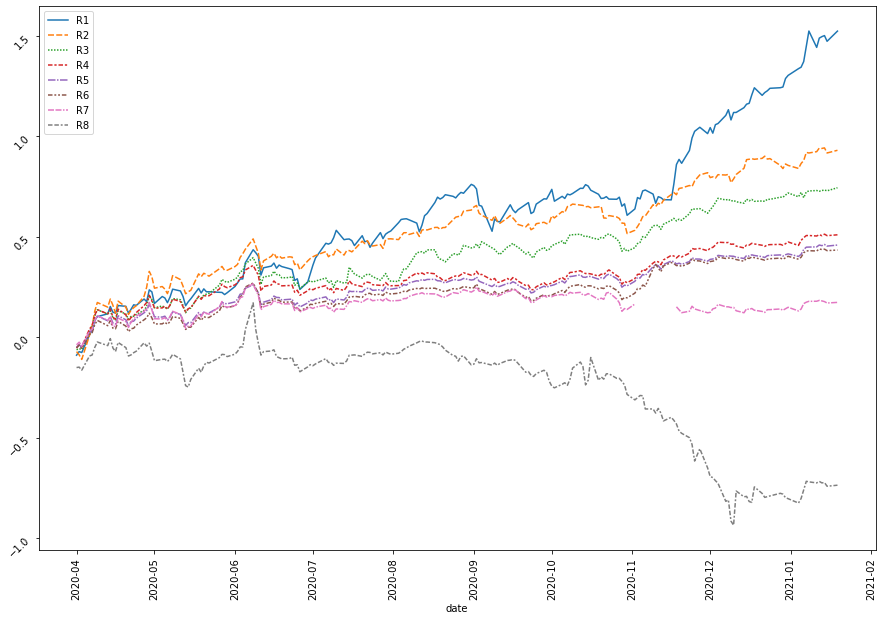

In [98]:
exam_df = prepared_df.reset_index()[['date','SCORE','weighted_rtn', 'log_rtn']]
exam_df = exam_df.groupby('date', as_index=True).apply(lambda x: x.sort_values('SCORE', ascending=False))
exam_df.index = exam_df.index.droplevel(1)
exam_df.drop(columns='date', inplace=True)

exam_df['rate'] = exam_df.groupby('date')['SCORE'].apply(lambda x : pd.cut(x, bins=8, labels=['R8', 'R7', 'R6','R5','R4','R3','R2','R1']))


x = exam_df.groupby(['date', 'rate'])['log_rtn'].apply(lambda x: x.sum()/len(x)).reset_index().set_index(['rate', 'date'])
z = pd.DataFrame(index=x.loc['R1'].index)
    
for i in range(1,9):
    z[f'R{i}'] = x.loc[f'R{i}',:].cumsum()
    
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.yticks(rotation=45)

sns.lineplot(data=z)

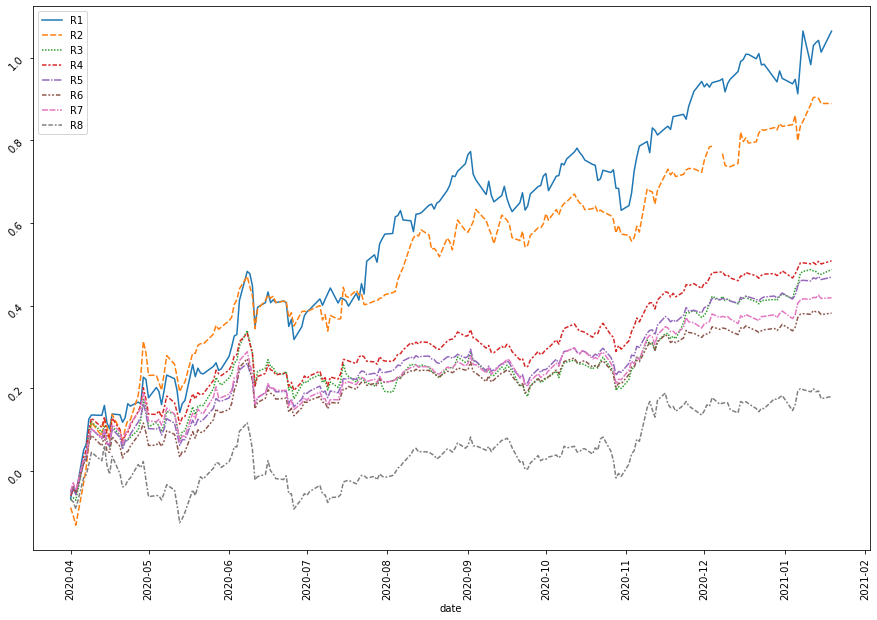

In [97]:
test = snp_scaffolding.copy()
test['sector'] = prepared_df['sector']
test['SCORE'] = prepared_df['SCORE']
test['log_rtn'] = prepared_df['log_rtn']
test.dropna(inplace=True)
test.index = test.index.droplevel(1)
test.reset_index().drop(columns='date', inplace=True)

test['rate'] = test.groupby('date')['SCORE'].apply(lambda x : pd.cut(x, bins=8, labels=['R8', 'R7', 'R6','R5','R4','R3','R2','R1']))
x = test.groupby(['date', 'rate'])['log_rtn'].apply(lambda x: x.sum()/len(x)).reset_index().set_index(['rate', 'date'])
z = pd.DataFrame(index=x.loc['R1'].index)
    
for i in range(1,9):
    z[f'R{i}'] = x.loc[f'R{i}',:].cumsum()
    
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.yticks(rotation=45)

sns.lineplot(data=z)